一，准备工作

1，包的安装

In [ ]:
#1，终端中安装使用pip
pip install 'scanpy[leiden]'
pip install python-igraph


#2，使用conda安装，采用法2
mamba create -n sc-python -c conda-forge -y scanpy python-igraph leidenalg python=3.12
conda activate sc-python

二， AnnData数据结构理解

1，构建模拟Anndata对象并查看

In [1]:
# 导包
import numpy as np
import pandas as pd
import anndata as ad #导入 anndata 库，并将其命名为 ad。anndata 是一个用于处理单细胞基因表达数据的库，提供了 AnnData 对象，用于存储和操作高维数据
from scipy.sparse import csr_matrix #从 scipy.sparse 模块中导入 csr_matrix 类。csr_matrix 是一种压缩稀疏行矩阵格式，用于高效存储和操作稀疏矩阵
print(ad.__version__)

0.11.3


In [2]:
# 模拟一个矩阵构建AnnData对象
counts = csr_matrix(np.random.poisson(1, size=(100, 2000)), dtype=np.float32) #将生成的随机矩阵转换为 scipy.sparse 模块中的压缩稀疏行矩阵（CSR 格式），并指定数据类型为 float32
temp_adata = ad.AnnData(counts) 
print(f"这个AnnData对象包括{temp_adata.shape[0]}行，与{temp_adata.shape[1]}列") #使用 anndata 库的 AnnData 类创建一个 AnnData 对象，并将稀疏矩阵 counts 作为数据存储在其中
# 稀疏矩阵存放在temp_adata.X中

这个AnnData对象包括100行，与2000列


In [7]:
# 生成细胞名称并传递给obs_names
temp_adata.obs_names = [f"Cell_{i:d}" for i in range(temp_adata.n_obs)]
# 生成基因名称并传递给var_names
temp_adata.var_names = [f"Gene_{i:d}" for i in range(temp_adata.n_vars)]

print(f"前五个细胞名称为:\n{temp_adata.obs_names[:5]}")

前五个细胞名称为:
Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4'], dtype='object')


In [ ]:
# 那么子集就可以这么取:行列切片
temp_adata[["Cell_1", "Cell_10"], ["Gene_5", "Gene_1900"]]
# 这样就得到了一个包含"两个细胞"、"两个基因"的表达矩阵

View of AnnData object with n_obs × n_vars = 2 × 2

2，添加注释信息

In [19]:
print(type(temp_adata.obs))
print(type(temp_adata.var))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [32]:
# 例如这里随机生成"B", "T", "Monocyte"三种细胞类型作为注释
ct = np.random.choice(["B", "T", "Monocyte"], size=(temp_adata.n_obs,))
print(f"ct的前10个元素为{ct[0:10]}")

# 加入adata.obs中

ct的前10个元素为['B' 'T' 'Monocyte' 'B' 'Monocyte' 'B' 'Monocyte' 'B' 'T' 'Monocyte']


In [41]:
temp_adata.obs["cell_type"] = pd.Categorical(ct)  # Categorical的执行效率较高

# 可以看到adata.obs已经包含了我们刚刚添加的注释
temp_adata.obs

cell_type
Cell_0          B
Cell_1          T
Cell_2   Monocyte
Cell_3          B
Cell_4   Monocyte
...           ...
Cell_95         B
Cell_96  Monocyte
Cell_97         T
Cell_98         B
Cell_99         T

[100 rows x 1 columns]

In [44]:
# 例如这里随机生成"Pathway_A", "Pathway_B", "Pathway_C"三种通路名作为细胞的注释
my_path = np.random.choice(["Pathway_A", "Pathway_B", "Pathway_C"],
                      size=(temp_adata.n_vars,))
print(f"ct的前10个元素为{my_path[0:10]}")

ct的前10个元素为['Pathway_B' 'Pathway_B' 'Pathway_C' 'Pathway_B' 'Pathway_A' 'Pathway_C'
 'Pathway_B' 'Pathway_C' 'Pathway_C' 'Pathway_C']


In [45]:
temp_adata.var["my_pathway"] = pd.Categorical(my_path)  # Categorical的执行效率较高

# 可以看到adata.var已经包含了我们刚刚添加的注释
temp_adata.var

my_pathway
Gene_0     Pathway_B
Gene_1     Pathway_B
Gene_2     Pathway_C
Gene_3     Pathway_B
Gene_4     Pathway_A
...              ...
Gene_1995  Pathway_B
Gene_1996  Pathway_B
Gene_1997  Pathway_A
Gene_1998  Pathway_C
Gene_1999  Pathway_C

[2000 rows x 1 columns]

In [46]:
# 这时这个AnnData对象就包含了我们所添加的cell_type以及my_pathway注释：
temp_adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    var: 'my_pathway'

In [52]:
# 这时可以通过注释来选取数据的子集：
# 取出B cell的细胞数据
bcell_adata = temp_adata[temp_adata.obs.cell_type == "B",:]

# 取出仅包含Pathway_A的基因数据：
PA_adata = temp_adata[:,temp_adata.var.my_pathway == "Pathway_A"]

In [57]:
# 构建一个略显"复杂"的注释DataFrame
obs_meta = pd.DataFrame({
        'time_yr': np.random.choice([0, 2, 4, 8], temp_adata.n_obs),
        'subject_id': np.random.choice(['subject 1', 'subject 2', 'subject 4', 'subject 8'], temp_adata.n_obs),
        'instrument_type': np.random.choice(['type a', 'type b'], temp_adata.n_obs),
        'site': np.random.choice(['site x', 'site y'], temp_adata.n_obs),
    },
    index=temp_adata.obs.index,   # 需要与AnnData的observations相一致
)
obs_meta.head()

time_yr subject_id instrument_type    site
Cell_0        2  subject 2          type b  site y
Cell_1        0  subject 2          type a  site x
Cell_2        2  subject 8          type a  site x
Cell_3        4  subject 8          type b  site x
Cell_4        4  subject 1          type b  site x

In [59]:
# 将注释添加到AnnData对象中:
new_adata = ad.AnnData(temp_adata.X, obs=obs_meta, var=temp_adata.var)

new_adata
# 可以看到多出很多注释内容

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'time_yr', 'subject_id', 'instrument_type', 'site'
    var: 'my_pathway'

3，注释矩阵管理

In [66]:
temp_adata.obsm["X_umap"] = np.random.normal(0, 1, size=(temp_adata.n_obs, 2))
temp_adata.varm["gene_stuff"] = np.random.normal(0, 1, size=(temp_adata.n_vars, 5))
temp_adata
# 可以看到X_umap与gene_stuff数据被添加

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    var: 'my_pathway'
    obsm: 'X_umap'
    varm: 'gene_stuff'

4，非结构性的注释信息

In [69]:
temp_adata.uns["random"] = [1, 2, 3]
temp_adata.uns

OrderedDict([('random', [1, 2, 3])])

5，Layers

In [78]:
temp_adata.layers["log_transformed"] = np.log1p(temp_adata.X)
temp_adata

AnnData object with n_obs × n_vars = 100 × 2000
    obs: 'cell_type'
    var: 'my_pathway'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

In [79]:
temp_adata.layers

Layers with keys: log_transformed

In [ ]:
temp_adata.to_df(layer="log_transformed")# Layer也可以直接转换为矩阵


Gene_0    Gene_1    Gene_2    Gene_3    Gene_4    Gene_5    Gene_6  \
Cell_0   0.693147  0.000000  1.609438  0.693147  0.000000  0.000000  0.000000   
Cell_1   1.609438  0.693147  0.693147  1.098612  0.693147  0.000000  0.000000   
Cell_2   0.000000  0.000000  0.693147  0.693147  0.693147  0.000000  0.693147   
Cell_3   0.693147  0.693147  0.693147  0.693147  0.693147  0.693147  0.000000   
Cell_4   1.098612  1.609438  0.000000  1.098612  1.098612  0.693147  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
Cell_95  0.693147  1.386294  0.000000  0.000000  1.386294  0.693147  0.693147   
Cell_96  0.693147  0.000000  1.098612  0.693147  0.693147  0.693147  1.386294   
Cell_97  1.098612  0.000000  0.693147  0.000000  1.098612  0.693147  0.693147   
Cell_98  0.000000  0.693147  1.609438  0.693147  0.693147  0.000000  0.000000   
Cell_99  0.693147  1.098612  1.098612  1.386294  0.693147  1.098612  0.693147   

           Gene_7    Gene_8    Gene_9  ...  Gene_1990  Gene_1991  Gene_1992  \
Cell_0   0.693147  1.386294  0.693147  ...   0.000000   0.000000   0.693147   
Cell_1   0.693147  0.693147  0.693147  ...   0.000000   0.693147   0.000000   
Cell_2   0.000000  0.693147  0.000000  ...   0.000000   1.386294   0.000000   
Cell_3   0.000000  0.000000  0.693147  ...   0.000000   1.386294   0.693147   
Cell_4   0.000000  0.000000  0.000000  ...   0.000000   1.098612   1.098612   
...           ...       ...       ...  ...        ...        ...        ...   
Cell_95  0.693147  1.386294  0.693147  ...   0.693147   0.000000   0.693147   
Cell_96  0.000000  0.693147  0.000000  ...   1.098612   0.693147   0.000000   
Cell_97  0.693147  0.000000  0.000000  ...   0.693147   0.000000   0.693147   
Cell_98  0.000000  0.000000  1.098612  ...   0.693147   0.000000   0.693147   
Cell_99  0.693147  0.693147  0.693147  ...   0.000000   1.098612   0.000000   

         Gene_1993  Gene_1994  Gene_1995  Gene_1996  Gene_1997  Gene_1998  \
Cell_0    0.693147   0.000000   0.693147   0.693147   0.693147   0.693147   
Cell_1    0.693147   0.693147   0.000000   0.000000   0.000000   0.693147   
Cell_2    0.000000   0.693147   0.000000   0.693147   0.000000   0.693147   
Cell_3    0.693147   0.693147   1.098612   0.000000   0.693147   0.000000   
Cell_4    1.098612   0.693147   0.693147   0.693147   0.000000   0.693147   
...            ...        ...        ...        ...        ...        ...   
Cell_95   0.693147   0.000000   0.693147   1.098612   0.693147   0.000000   
Cell_96   0.000000   1.098612   0.693147   0.693147   0.000000   1.098612   
Cell_97   0.000000   0.000000   0.693147   0.000000   0.693147   1.098612   
Cell_98   0.000000   1.386294   1.791759   0.693147   0.000000   1.098612   
Cell_99   0.000000   1.098612   1.386294   0.000000   0.693147   0.693147   

         Gene_1999  
Cell_0    1.386294  
Cell_1    0.693147  
Cell_2    1.098612  
Cell_3    0.000000  
Cell_4    0.693147  
...            ...  
Cell_95   0.000000  
Cell_96   0.693147  
Cell_97   0.000000  
Cell_98   0.000000  
Cell_99   0.693147  

[100 rows x 2000 columns]

In [83]:
# 也可以输出为csv文件：当然前面转换为数据框之后可以直接导出为csv文件
temp_adata.to_df(layer="log_transformed").to_csv("log_transformed.csv")

6，AnnData存储与读取

In [ ]:
#保存为h5ad格式
temp_adata.write('my_results.h5ad', compression="gzip")

In [91]:
adata = ad.read('my_results.h5ad', backed='r')
adata.isbacked #此时my_results.h5ad处于open状态，即被占用的状态

/home/csn/program/miniconda3/envs/sc-python/lib/python3.12/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


True

In [110]:
adata = ad.read_h5ad('my_results.h5ad', backed='r')
adata.isbacked #此时my_results.h5ad处于open状态，即被占用的状态，输出为True

# 此时adata可以被正常使用，且多出路径变量
adata.filename

# 当完成分析时可以解除占用：
adata.file.close() 
# 这其实就是scanpy在分析相同的数据比Seurat占用更少内存的秘诀

7，AnnData的Views与copies

In [111]:
# 在做View时候也可以使用切片：
temp_adata[:5, ['Gene_1', 'Gene_3']]

View of AnnData object with n_obs × n_vars = 5 × 2
    obs: 'cell_type'
    var: 'my_pathway'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

In [112]:
# 而copy的方式会占据额外的内存
adata_subset = temp_adata[:5, ['Gene_1', 'Gene_3']].copy()
adata_subset

AnnData object with n_obs × n_vars = 5 × 2
    obs: 'cell_type'
    var: 'my_pathway'
    uns: 'random'
    obsm: 'X_umap'
    varm: 'gene_stuff'
    layers: 'log_transformed'

三，单样本分析

1，数据准备

In [12]:
#以下命令建议在shell中执行
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzvf ./pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write    

mkdir: cannot create directory ‘data’: File exists
--2025-02-11 10:00:17--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2025-02-11 10:00:19--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  4.30MB/s    in 1.7s    

2025-02-11 10:00:23

2，数据文件结构

In [ ]:
my_barcode = pd.read_csv('./data/filtered_gene_bc_matrices/hg19/barcodes.tsv',
                         sep="\t",header = None)   #没有列名
print(f"barcodes.tsv文件中的内容为:\n--------------------")
my_barcode.head() ## 顾名思义，这个文件中包含的是细胞的barcode信息

barcodes.tsv文件中的内容为:
--------------------


0
0  AAACATACAACCAC-1
1  AAACATTGAGCTAC-1
2  AAACATTGATCAGC-1
3  AAACCGTGCTTCCG-1
4  AAACCGTGTATGCG-1

In [ ]:
my_genes = pd.read_csv('./data/filtered_gene_bc_matrices/hg19/genes.tsv',
                         sep="\t",header = None)
print(f"genes.tsv文件中的内容为:\n--------------------")
my_genes.head()
# 共包含两列，一列为基因ID，一列为基因SYMBOLS

genes.tsv文件中的内容为:
--------------------


0             1
0  ENSG00000243485    MIR1302-10
1  ENSG00000237613       FAM138A
2  ENSG00000186092         OR4F5
3  ENSG00000238009  RP11-34P13.7
4  ENSG00000239945  RP11-34P13.8

In [14]:
my_matrix = pd.read_csv('./data/filtered_gene_bc_matrices/hg19/matrix.mtx',
                         sep="\t",header = 0) #第0行作为列名
print(f"matrix.mtx文件中的内容为:\n--------------------")
my_matrix.head()
# 当中包含的是稀疏矩阵，记录了单细胞的表达信息

matrix.mtx文件中的内容为:
--------------------


%%MatrixMarket matrix coordinate real general
0                                             %
1                            32738 2700 2286884
2                                     32709 1 4
3                                     32707 1 1
4                                    32706 1 10

In [9]:
my_matrix = pd.read_csv('./data/filtered_gene_bc_matrices/hg19/matrix.mtx',
                         sep="\t",skiprows=2,header=None) #第0行作为列名
print(f"matrix.mtx文件中的内容为:\n--------------------")
my_matrix.head()
# 当中包含的是稀疏矩阵，记录了单细胞的表达信息

matrix.mtx文件中的内容为:
--------------------


0
0  32738 2700 2286884
1           32709 1 4
2           32707 1 1
3          32706 1 10
4           32704 1 1

3，数据读取

3.1，导包

In [32]:
# 先设置工作路径：
import os
os.makedirs('/zht/scanpy/',exist_ok=True)
os.chdir('/zht/scanpy/')#更改路径

print(os.getcwd())#显示当前路径

/zht/scanpy


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

3.2，全局设置

In [2]:
# 进度条设置
sc.settings.verbosity = 3             
# verbosity: errors (0), warnings (1), info (2), hints (3)

# 输出日志只展示开头信息,用于打印可能影响数值结果的各种依赖包的版本信息
sc.logging.print_header()

# 输出图片分辨率设置，这里演示为80，建议实际运行时设置为300（一般投稿要求）
sc.settings.set_figure_params(facecolor='white', dpi=100, fontsize=10, dpi_save=300, figsize=(10, 7), format="pdf")

# 这个函数是设置图片的尺寸，这个跟R语言中就很不一样，一般R语言会在输出环节再设置。
# scanpy: 如果为True，使用Scanpy的默认matplotlib设置。
# dpi: 图像显示的分辨率。
# dpi_save: 保存图像的分辨率。
# frameon: 是否在图像周围显示框架。
# vector_friendly: 是否生成对矢量图友好的输出。
# fontsize: 图形中使用的字体大小。
# figsize: 图形的尺寸，如果为None，则使用默认尺寸。
# color_map: 使用的颜色映射。
# format: 保存图形时使用的格式。
# facecolor: 图形的背景颜色，如果为None，使用默认颜色。
# transparent: 是否使图形背景透明。
# ipython_format: 在Jupyter Notebook中显示图形时使用的格式。


# 设置输出文件名：
results_file = 'write/pbmc3k.h5ad'

scanpy==1.10.4 anndata==0.11.3 umap==0.5.7 numpy==2.1.3 scipy==1.15.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


3.3，数据读取

In [3]:
# 读入时scanpy会自动在内存中创建h5ad
adata = sc.read_10x_mtx(
    '/zht/data/filtered_gene_bc_matrices/hg19/',# 包含数据文件的文件夹地址
    var_names='gene_symbols',  # 设置利用基因SYMBOL作为变量名，后续可以作为索引获取对应数据
    cache=True)  
print(f"adata的变量类型为：\n{type(adata)}\n----------")

... reading from cache file cache/zht-data-filtered_gene_bc_matrices-hg19-matrix.h5ad
adata的变量类型为：
<class 'anndata._core.anndata.AnnData'>
----------


In [4]:
print(adata.var_names)

# 将 adata.var_names 转换为 pandas Series
var_names_series = pd.Series(adata.var_names)

# 检查是否存在重复值
has_duplicates = var_names_series.duplicated().any()

if has_duplicates:
    print("存在重复值。")
    # 打印重复值
    duplicates = var_names_series[var_names_series.duplicated()]
    print("重复值如下：")
    print(duplicates)
else:
    print("没有重复值。")
    
print(var_names_series)

Index(['MIR1302-10', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8',
       'AL627309.1', 'RP11-34P13.14', 'RP11-34P13.9', 'AP006222.2',
       'RP4-669L17.10',
       ...
       'KIR3DL2-1', 'AL590523.1', 'CT476828.1', 'PNRC2-1', 'SRSF10-1',
       'AC145205.1', 'BAGE5', 'CU459201.1', 'AC002321.2', 'AC002321.1'],
      dtype='object', length=32738)
没有重复值。
0          MIR1302-10
1             FAM138A
2               OR4F5
3        RP11-34P13.7
4        RP11-34P13.8
             ...     
32733      AC145205.1
32734           BAGE5
32735      CU459201.1
32736      AC002321.2
32737      AC002321.1
Length: 32738, dtype: object


In [5]:
# #如果使用var_names="gene_symbols"这一参数加载数据，可能会有重复的基因名字出现，因为一个symbol是有可能对应不止一个gene id的
#这时候就需要下面这句代码，这句代码会添加额外字符来使基因名唯一化
# 在读取数据时候，若选择var_names='gene_ids'，则不需要此步控制.var唯一
adata.var_names_make_unique()  

3.4，数据处理

normalizing counts per cell
    finished (0:00:00)


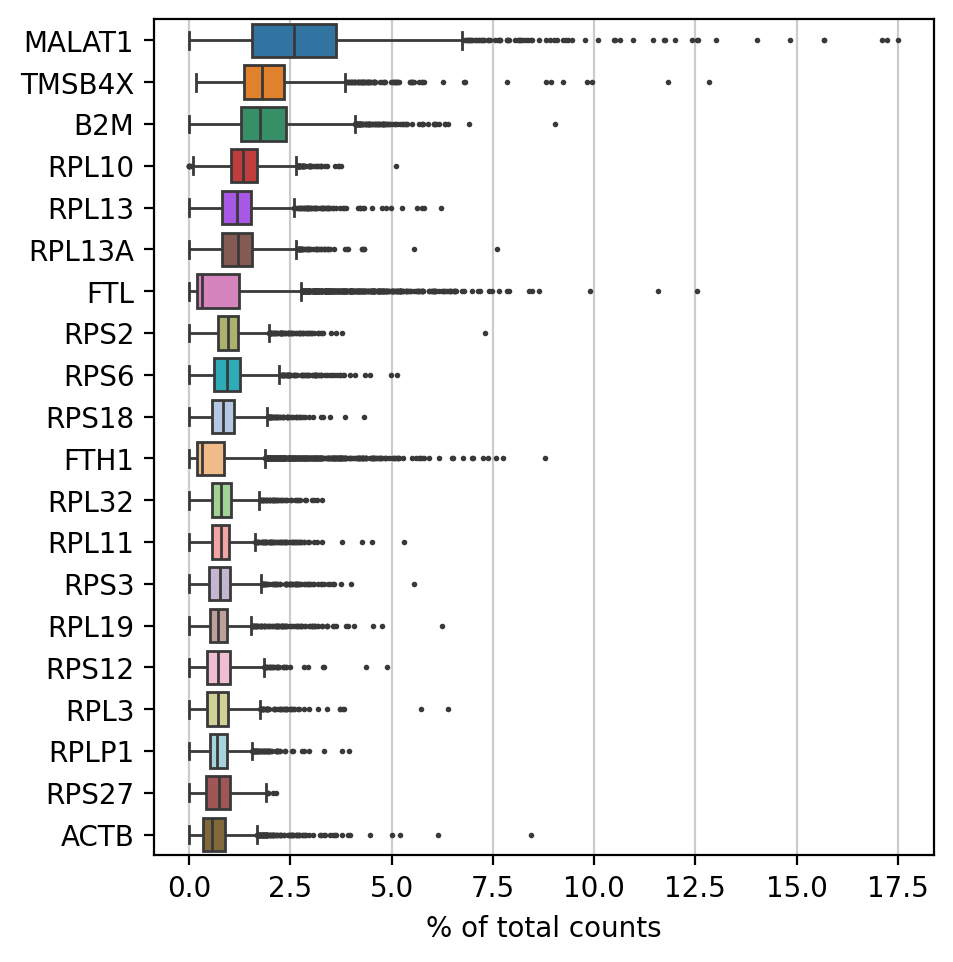

In [6]:
#显示在所有细胞中在每个单细胞中产生最高计数分数的基因
# 计算并以箱线图的形式展示表达量最高的二十个基因：

#绘制每个基因在所有细胞中的计数分数的图形，n_top参数表示要显示的基因数量
#统计基因在细胞中的占比并可视化
#每一个gene在一个cell中占据所有cell的表达量有一个值，类似于reads，或者是counts，或者是bulk中的TPM等值，总之这个值可以计算比例；然后我们计算所有细胞中这个gene的比例，那就是总共有cell数目个比例，再然后就是绘制箱线图，也就是每一个基因在所有细胞中的平均表达量（这里计算了百分比含量）
sc.pl.highest_expr_genes(adata, n_top=20, ) 


In [7]:
# 过滤低质量细胞样本:过滤在少于三个细胞中表达，或一个细胞中表达少于200个基因的细胞样本

# 过滤掉表达基因数量不足两百的细胞：
sc.pp.filter_cells(adata, min_genes=200)

# 过滤掉表达细胞数量不足3个的基因：
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [8]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [9]:
# 过滤包含线粒体基因和表达基因过多的细胞
# 线粒体基因的转录本比单个转录物分子大，并且不太可能通过细胞膜逃逸。因此，检测出高比例的线粒体基因，表明细胞质量差（Islam et al. 2014; Ilicic et al. 2016）。表达基因过多可能是由于一个油滴包裹多个细胞，从而检测出比正常检测要多的基因数，因此要过滤这些细胞。

# 由于死细胞胞浆中RNA丢失等因素，死细胞的线粒体mRNA(mt-mRNA)的含量通常较高
# 我们需要进行计算并设置合理的阈值进行过滤。
# 注释mt-mRNA为"mt":
adata.var['mt'] = adata.var_names.str.startswith('MT-') # 此处为人类，固用^MT，小鼠需要换为^mt
# 计算mt-mRNA含量:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [10]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [11]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt  
AAACATACAACCAC-1       3.017776  
AAACATTGAGCTAC-1       3.793596  
AAACATTGATCAGC-1       0.889736  
AAACCGTGCTTCCG-1       1.743085  
AAACCGTGTATGCG-1       1.224490  
...                         ...  
TTTCGAACTCTCAT-1       2.110436  
TTTCTACTGAGGCA-1       0.929422  
TTTCTACTTCCTCG-1       2.197150  
TTTGCATGAGAGGC-1       2.054795  
TTTGCATGCCTCAC-1       0.806452  

[2700 rows x 5 columns]

In [12]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
AL627309.1     ENSG00000237683        9  False                  9   
AP006222.2     ENSG00000228463        3  False                  3   
RP11-206L10.2  ENSG00000228327        5  False                  5   
RP11-206L10.9  ENSG00000237491        3  False                  3   
LINC00115      ENSG00000225880       18  False                 18   
...                        ...      ...    ...                ...   
AC145212.1     ENSG00000215750       16  False                 16   
AL592183.1     ENSG00000220023      323  False                323   
AL354822.1     ENSG00000215615        8  False                  8   
PNRC2-1        ENSG00000215700      110  False                110   
SRSF10-1       ENSG00000215699       69  False                 69   

               mean_counts  pct_dropout_by_counts  total_counts  
AL627309.1        0.003333              99.666667           9.0  
AP006222.2        0.001111              99.888889           3.0  
RP11-206L10.2     0.001852              99.814815           5.0  
RP11-206L10.9     0.001111              99.888889           3.0  
LINC00115         0.006667              99.333333          18.0  
...                    ...                    ...           ...  
AC145212.1        0.006667              99.407407          18.0  
AL592183.1        0.134815              88.037037         364.0  
AL354822.1        0.002963              99.703704           8.0  
PNRC2-1           0.042963              95.925926         116.0  
SRSF10-1          0.025926              97.444444          70.0  

[13714 rows x 7 columns]

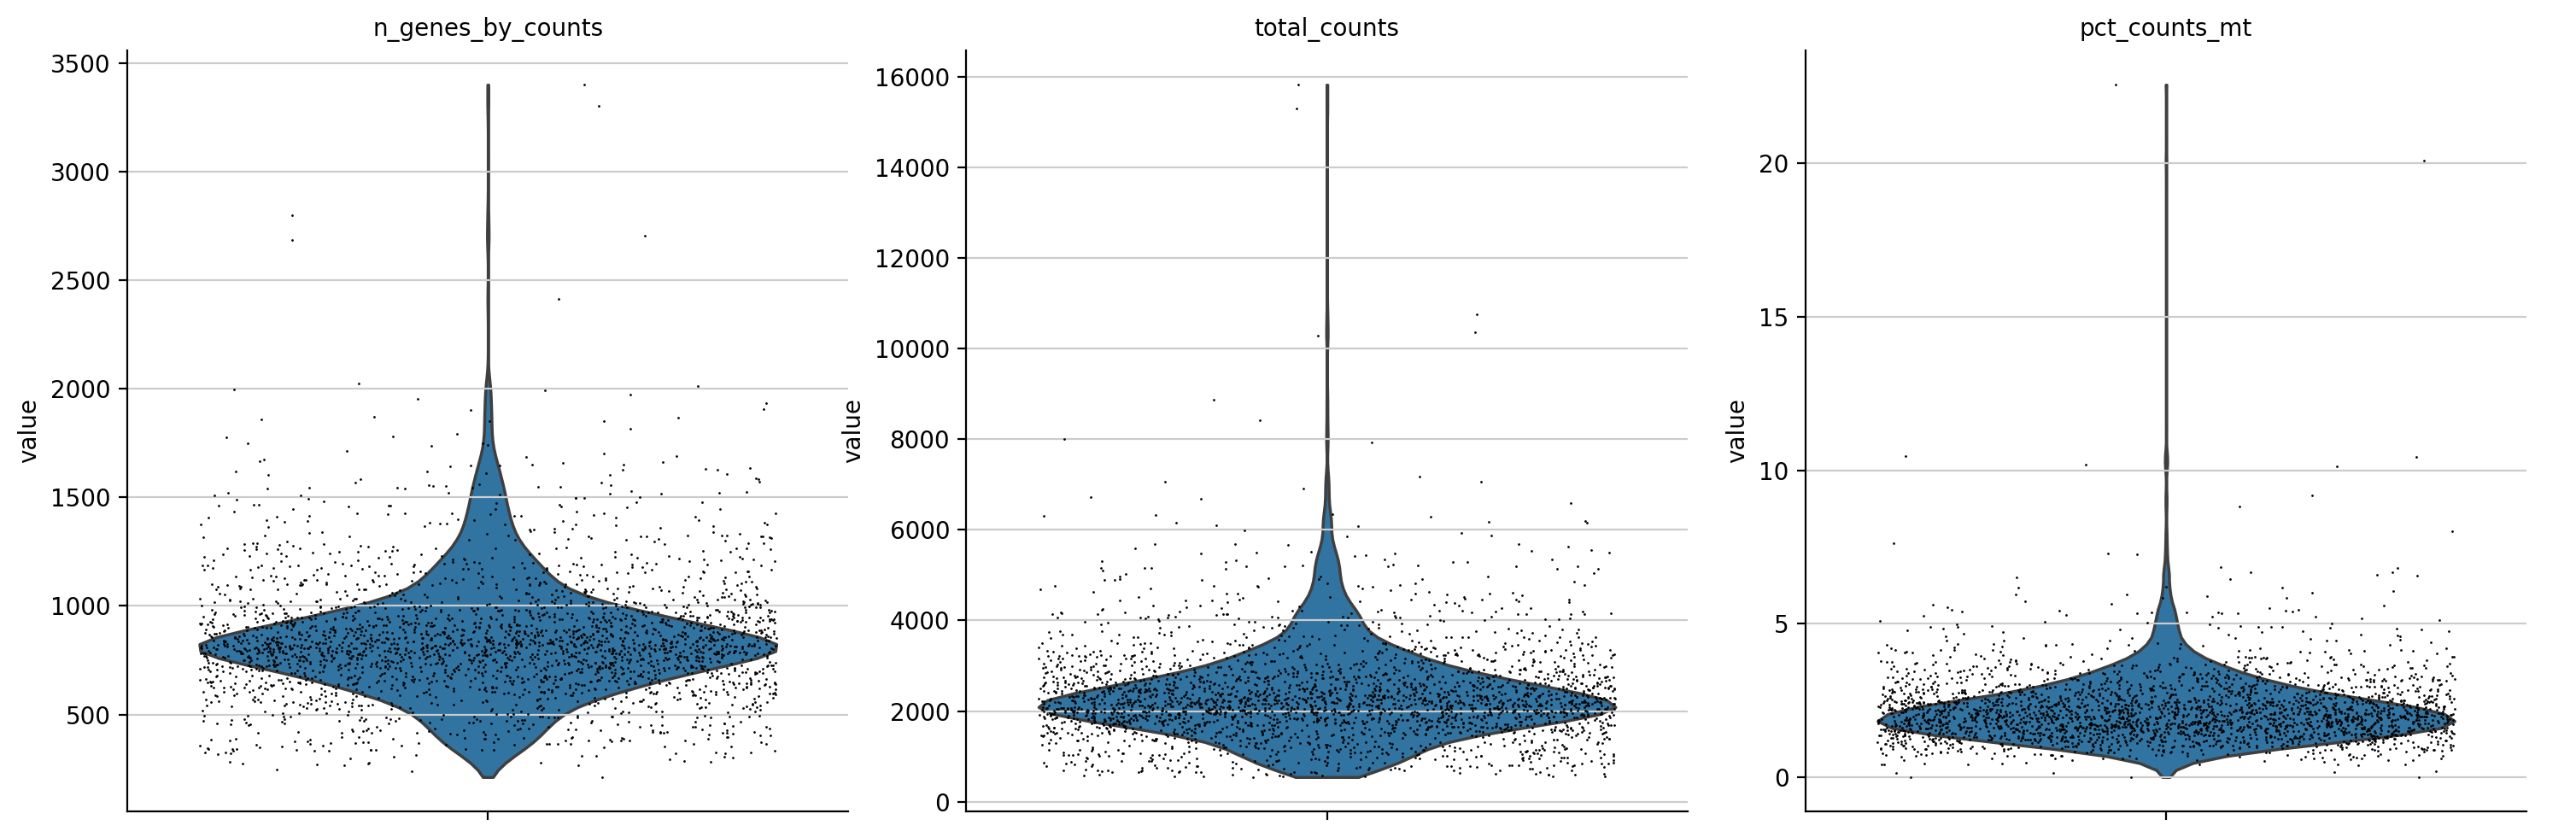

In [13]:
# 可视化n_genes_by_counts、total_counts、pct_counts_mt等质控指标
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [14]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

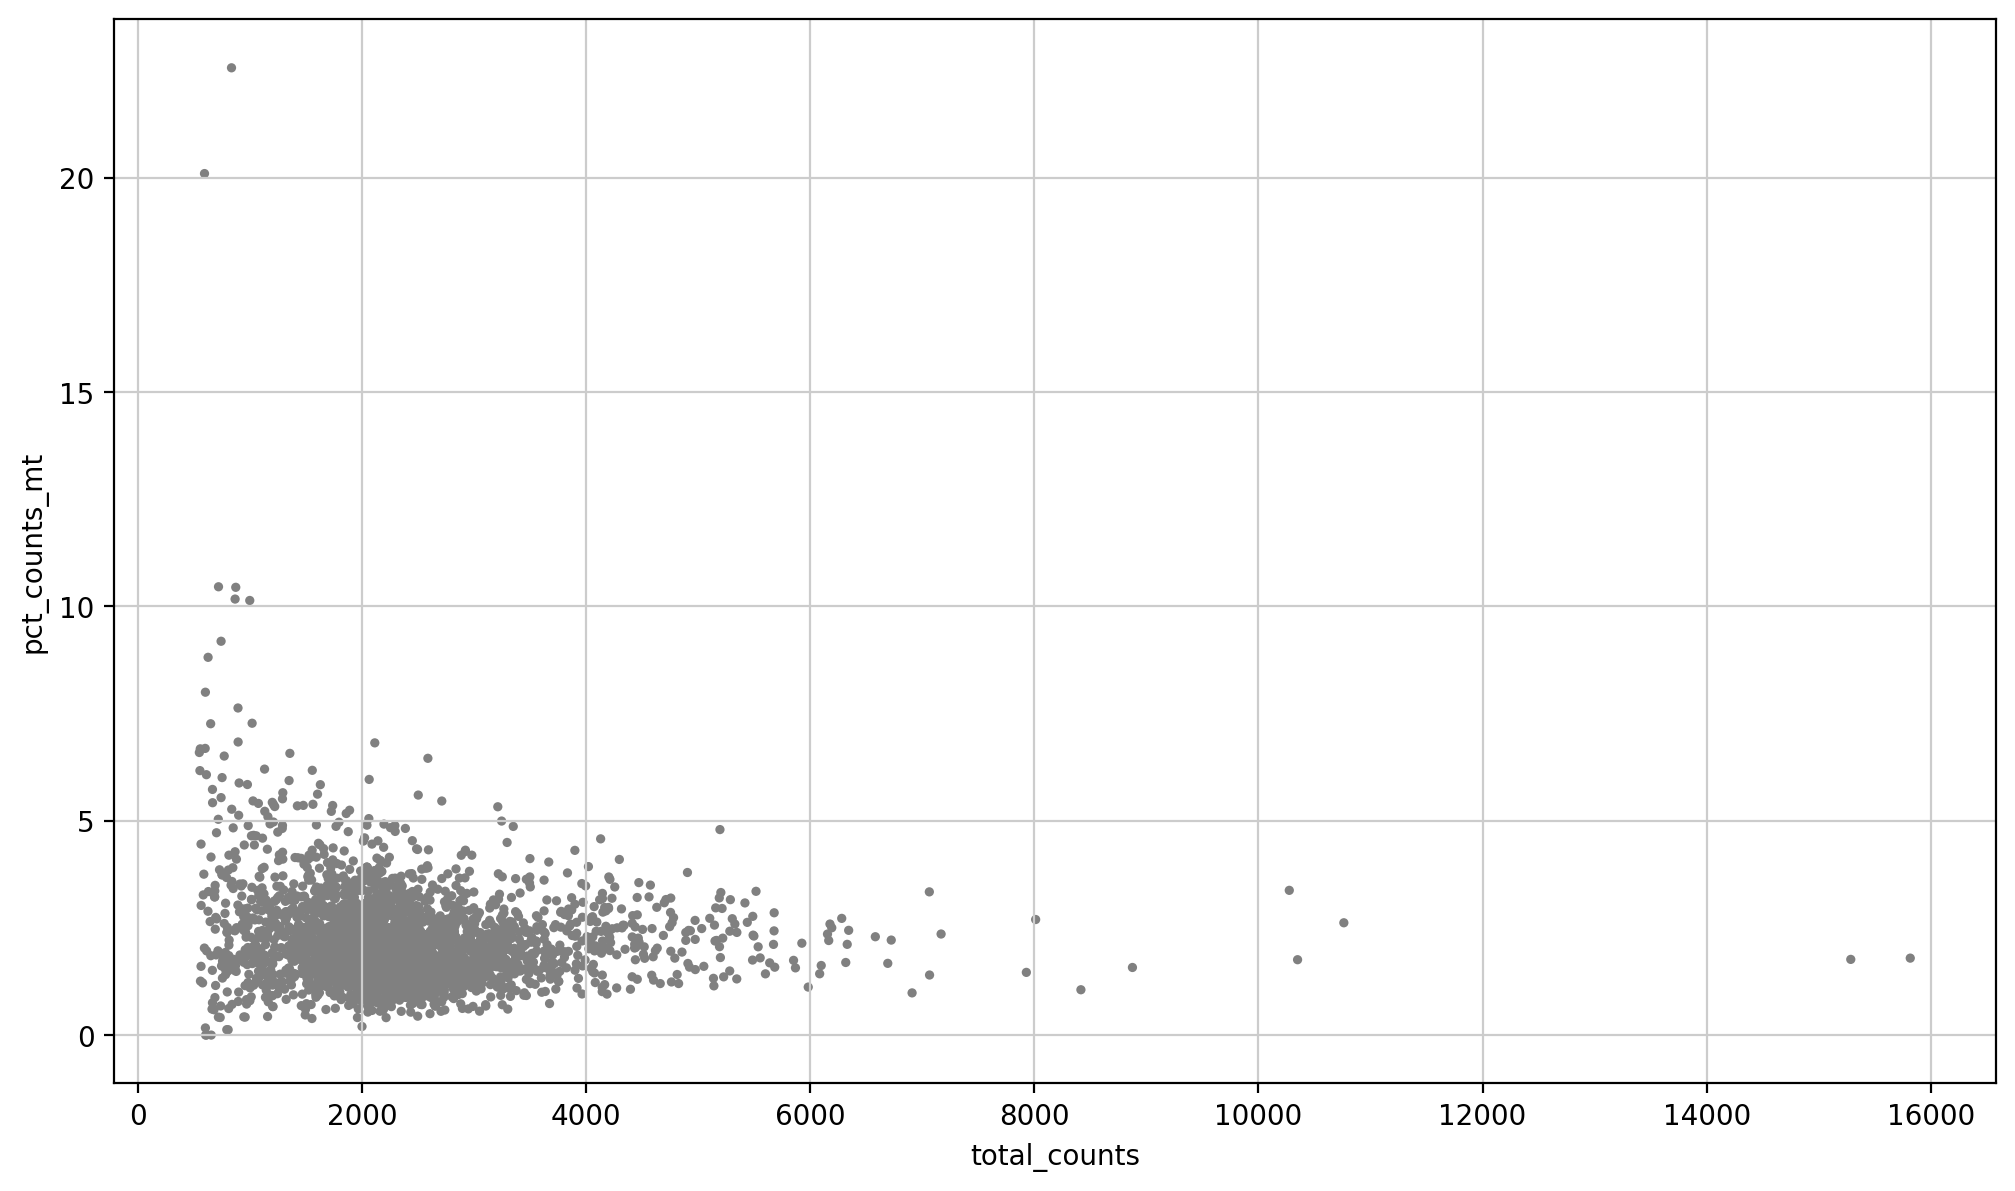

In [15]:
# 展现线粒体count与细胞总count的相关性：
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')

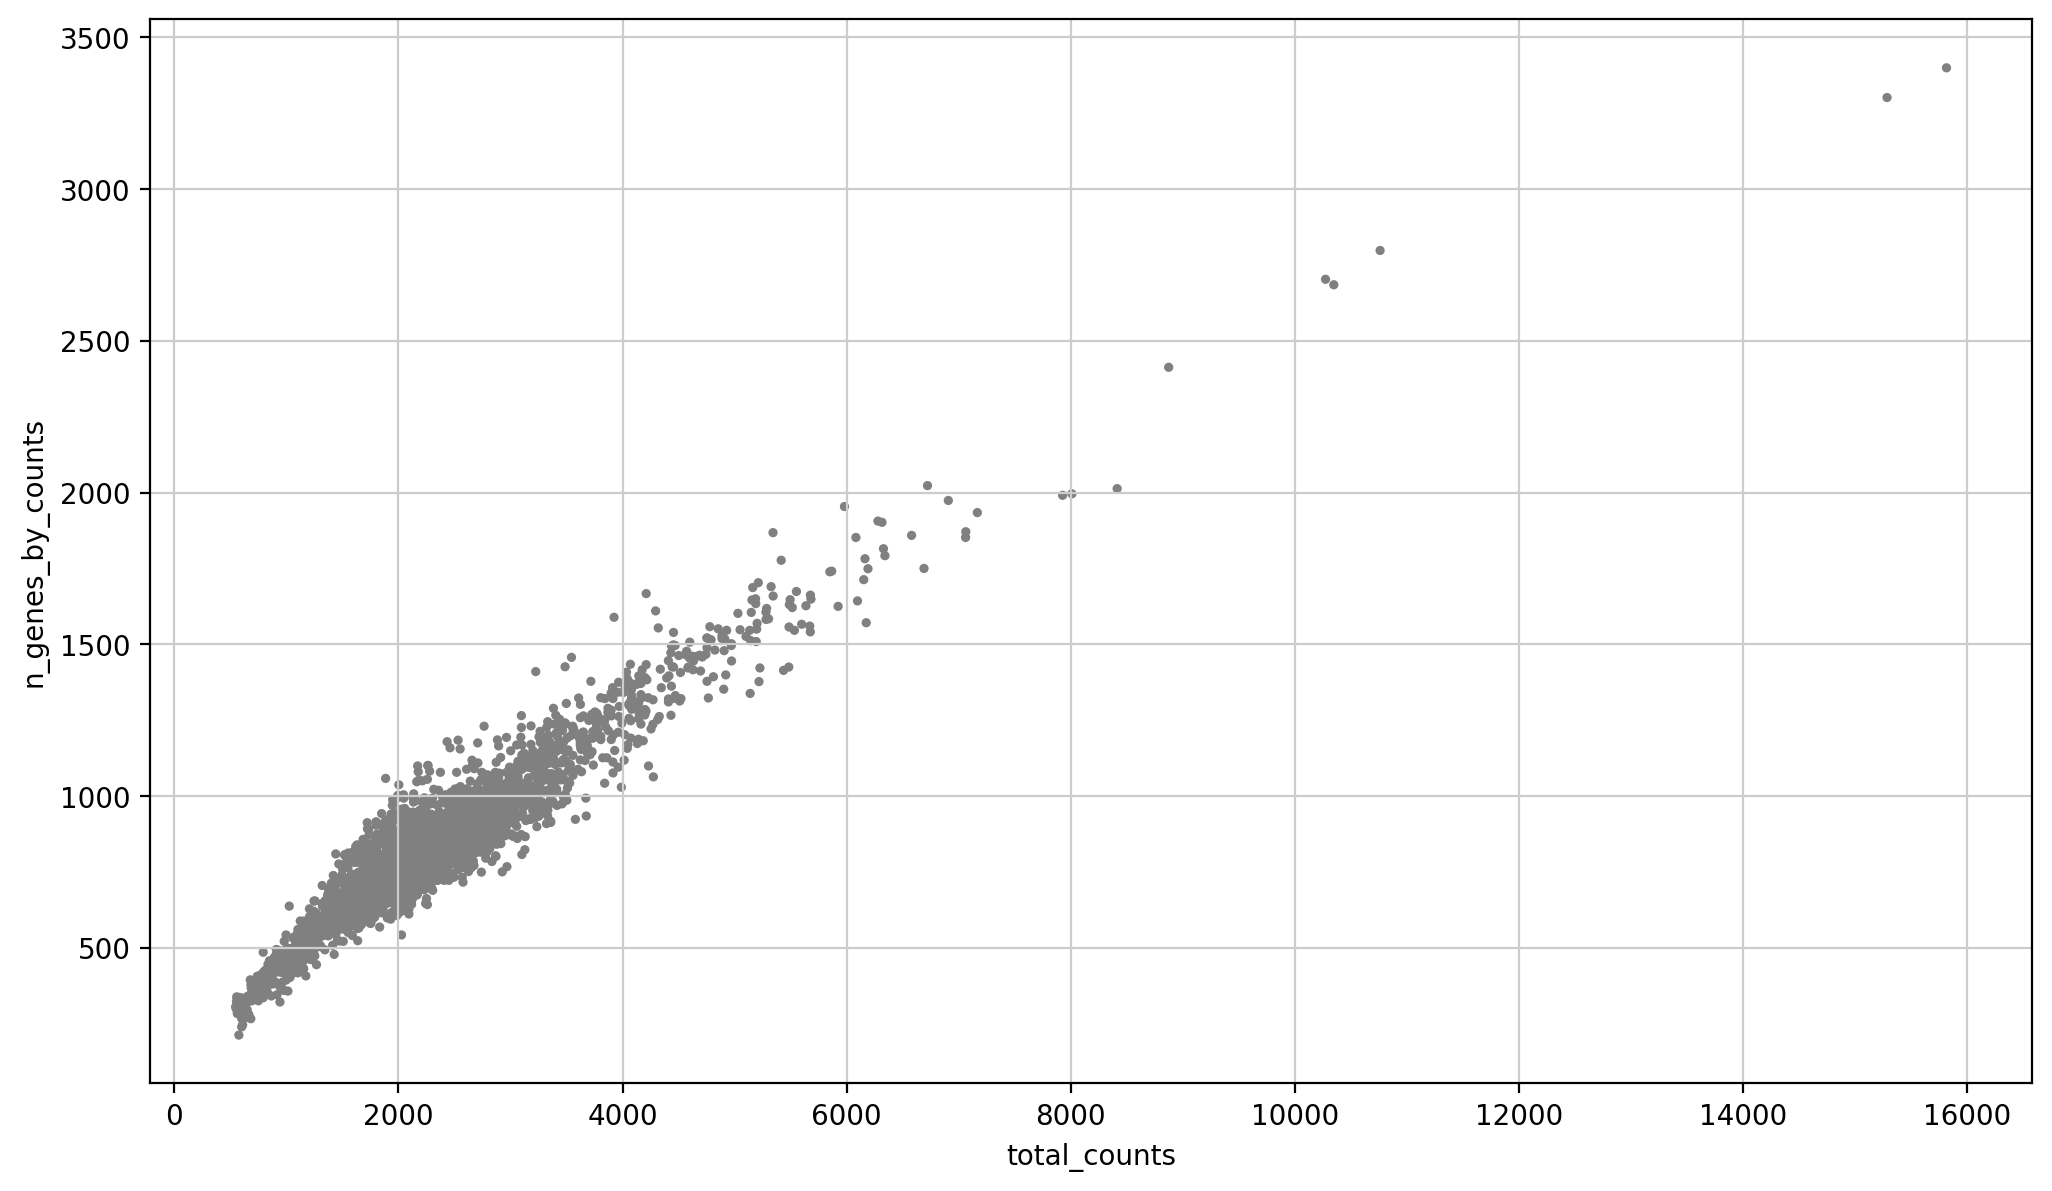

In [16]:
# 展现细胞基因数量与细胞总count间的相关性
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [17]:
#过滤线粒体基因表达过多或总数过多的细胞，也就是上面两张散点图所展示的cell主要分布范围，将分布范围外的细胞过滤掉

# 保留每个细胞中表达基因少于2500的细胞
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
# 保留细胞中mt-mRNA的counts比例小于5%的细胞
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [18]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [19]:
# 检测特异性表达基因,归一化，使得不同细胞样本间可比

# 标准化数据，将每个细胞的reads数标准化至10,000，
# 这使得相同基因在不同细胞之间的表达量比较成为可能
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/home/csn/program/miniconda3/envs/sc-python/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
# 对表达矩阵进行log(X+1)的操作
sc.pp.log1p(adata)

In [21]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [22]:
# 计算高变基因,识别特异性基因
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [23]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [24]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
AL627309.1     ENSG00000237683        9  False                  9   
AP006222.2     ENSG00000228463        3  False                  3   
RP11-206L10.2  ENSG00000228327        5  False                  5   
RP11-206L10.9  ENSG00000237491        3  False                  3   
LINC00115      ENSG00000225880       18  False                 18   
...                        ...      ...    ...                ...   
AC145212.1     ENSG00000215750       16  False                 16   
AL592183.1     ENSG00000220023      323  False                323   
AL354822.1     ENSG00000215615        8  False                  8   
PNRC2-1        ENSG00000215700      110  False                110   
SRSF10-1       ENSG00000215699       69  False                 69   

               mean_counts  pct_dropout_by_counts  total_counts  \
AL627309.1        0.003333              99.666667           9.0   
AP006222.2        0.001111              99.888889           3.0   
RP11-206L10.2     0.001852              99.814815           5.0   
RP11-206L10.9     0.001111              99.888889           3.0   
LINC00115         0.006667              99.333333          18.0   
...                    ...                    ...           ...   
AC145212.1        0.006667              99.407407          18.0   
AL592183.1        0.134815              88.037037         364.0   
AL354822.1        0.002963              99.703704           8.0   
PNRC2-1           0.042963              95.925926         116.0   
SRSF10-1          0.025926              97.444444          70.0   

               highly_variable     means  dispersions  dispersions_norm  
AL627309.1               False  0.013556     1.432845         -0.624328  
AP006222.2               False  0.004696     1.458631         -0.573416  
RP11-206L10.2            False  0.005673     1.325459         -0.836358  
RP11-206L10.9            False  0.002644     0.859264         -1.756848  
LINC00115                False  0.027437     1.457477         -0.575693  
...                        ...       ...          ...               ...  
AC145212.1               False  0.027441     1.784637          0.070275  
AL592183.1               False  0.485051     1.859941         -0.437388  
AL354822.1               False  0.012157     1.781924          0.064919  
PNRC2-1                  False  0.160366     1.567491         -0.358474  
SRSF10-1                 False  0.100255     1.544864         -0.403150  

[13714 rows x 11 columns]

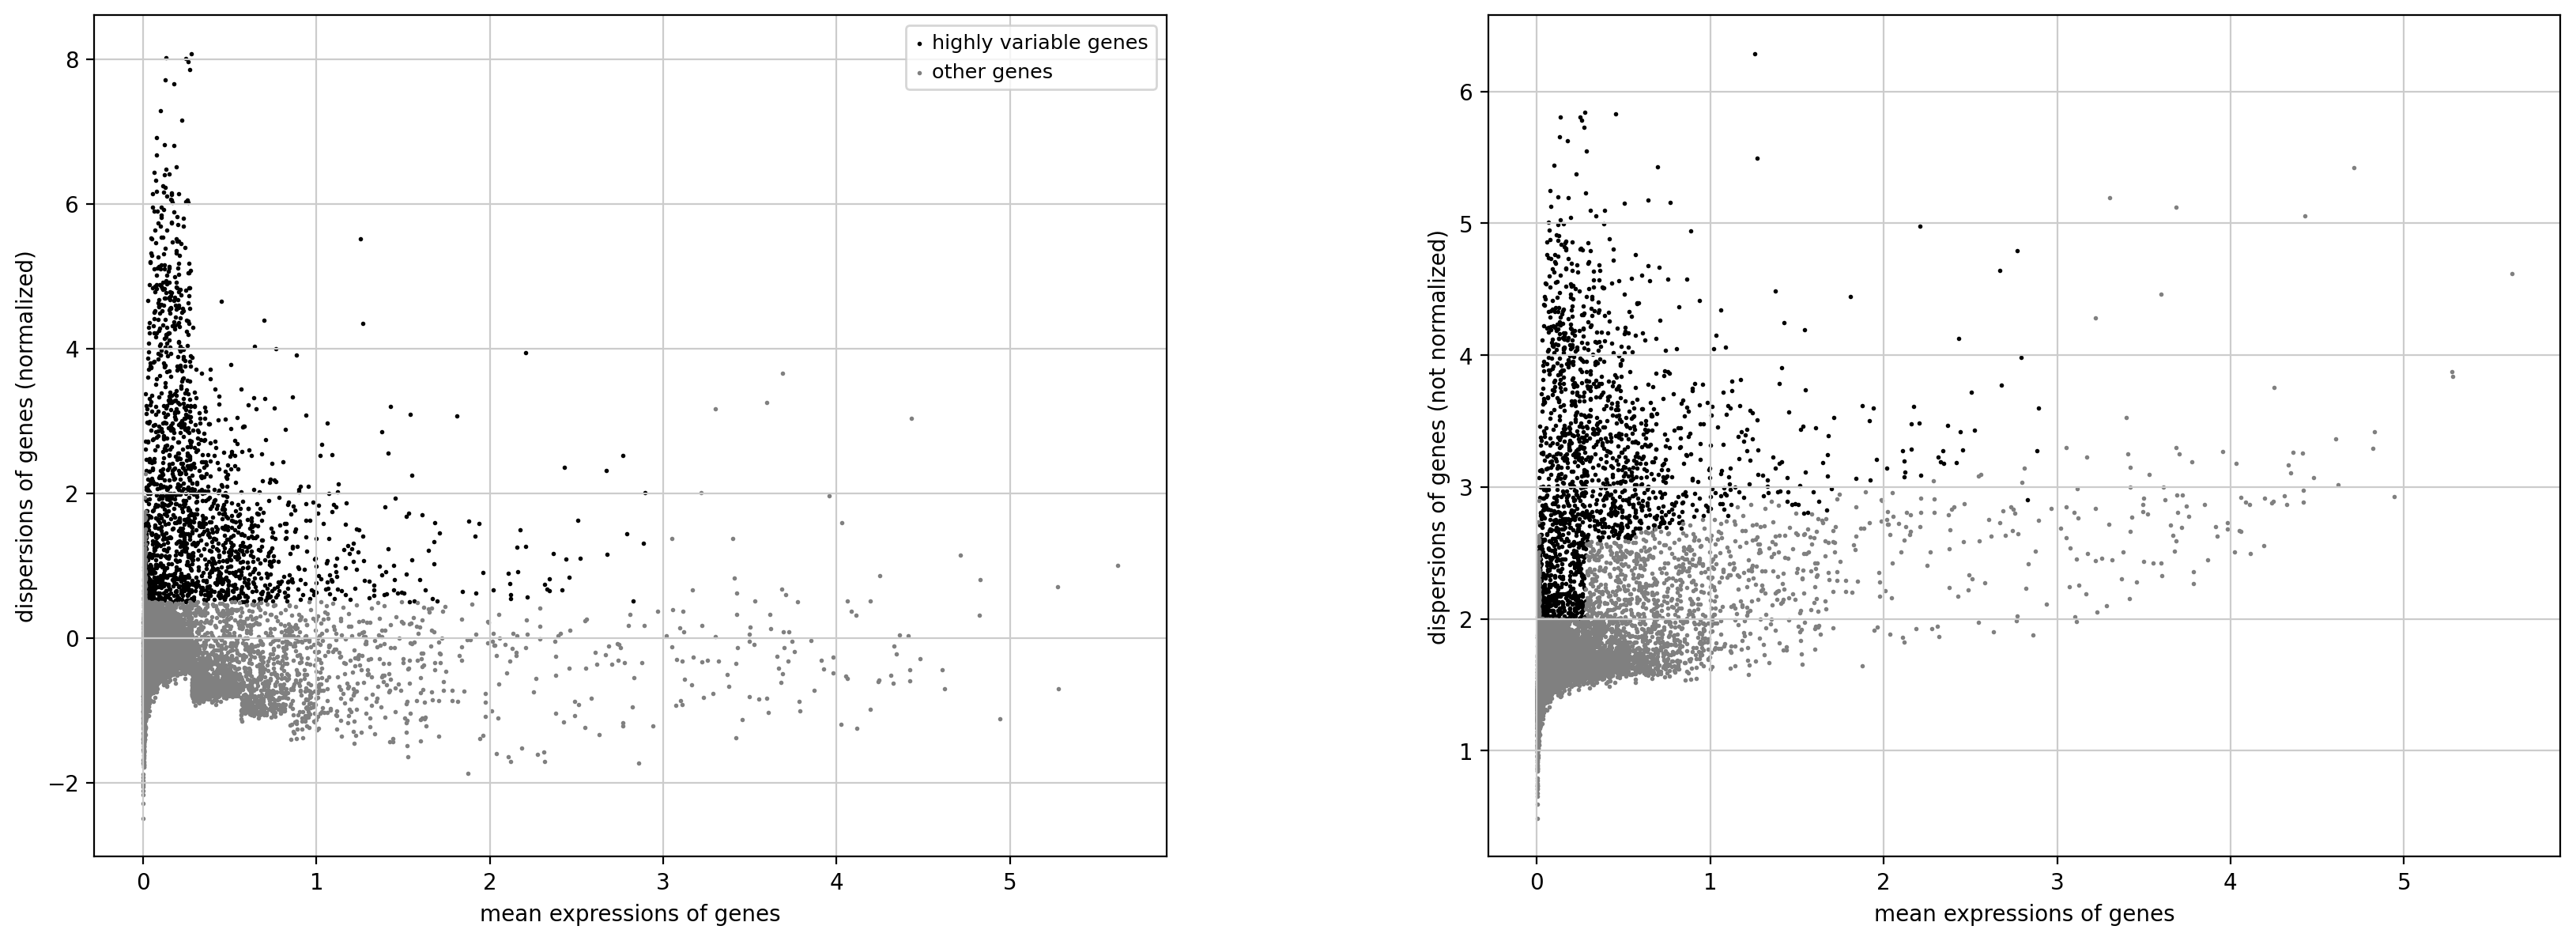

In [25]:
# 绘制特异性基因散点图
# 可视化基因离散度与平均表达量之间的关系
sc.pl.highly_variable_genes(adata)

In [26]:
# 利用view操作对AnnData做一个备份：
adata.raw = adata
# 这样就能保证你在下游操作失误或想回溯原始数据时具有方便的接口
adata.raw

In [27]:
adata.var

gene_ids  n_cells     mt  n_cells_by_counts  \
AL627309.1     ENSG00000237683        9  False                  9   
AP006222.2     ENSG00000228463        3  False                  3   
RP11-206L10.2  ENSG00000228327        5  False                  5   
RP11-206L10.9  ENSG00000237491        3  False                  3   
LINC00115      ENSG00000225880       18  False                 18   
...                        ...      ...    ...                ...   
AC145212.1     ENSG00000215750       16  False                 16   
AL592183.1     ENSG00000220023      323  False                323   
AL354822.1     ENSG00000215615        8  False                  8   
PNRC2-1        ENSG00000215700      110  False                110   
SRSF10-1       ENSG00000215699       69  False                 69   

               mean_counts  pct_dropout_by_counts  total_counts  \
AL627309.1        0.003333              99.666667           9.0   
AP006222.2        0.001111              99.888889           3.0   
RP11-206L10.2     0.001852              99.814815           5.0   
RP11-206L10.9     0.001111              99.888889           3.0   
LINC00115         0.006667              99.333333          18.0   
...                    ...                    ...           ...   
AC145212.1        0.006667              99.407407          18.0   
AL592183.1        0.134815              88.037037         364.0   
AL354822.1        0.002963              99.703704           8.0   
PNRC2-1           0.042963              95.925926         116.0   
SRSF10-1          0.025926              97.444444          70.0   

               highly_variable     means  dispersions  dispersions_norm  
AL627309.1               False  0.013556     1.432845         -0.624328  
AP006222.2               False  0.004696     1.458631         -0.573416  
RP11-206L10.2            False  0.005673     1.325459         -0.836358  
RP11-206L10.9            False  0.002644     0.859264         -1.756848  
LINC00115                False  0.027437     1.457477         -0.575693  
...                        ...       ...          ...               ...  
AC145212.1               False  0.027441     1.784637          0.070275  
AL592183.1               False  0.485051     1.859941         -0.437388  
AL354822.1               False  0.012157     1.781924          0.064919  
PNRC2-1                  False  0.160366     1.567491         -0.358474  
SRSF10-1                 False  0.100255     1.544864         -0.403150  

[13714 rows x 11 columns]

In [28]:
adata.var.highly_variable

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [29]:
# 过滤，仅保留高变基因,获取只有特异性基因的数据集
adata = adata[:, adata.var.highly_variable]

# 回归排除细胞counts总数与线粒体含量对下游分析造成的影响
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# 计算每个基因的单位方差，剪辑标准偏差超过10的值，完成“缩放”过程，
# 让每个基因在下游参与降维分群过程中处于“平等”的地位。
sc.pp.scale(adata, max_value=10)


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/csn/program/miniconda3/envs/sc-python/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:02)


computing PCA
    with n_comps=50
    finished (0:00:00)


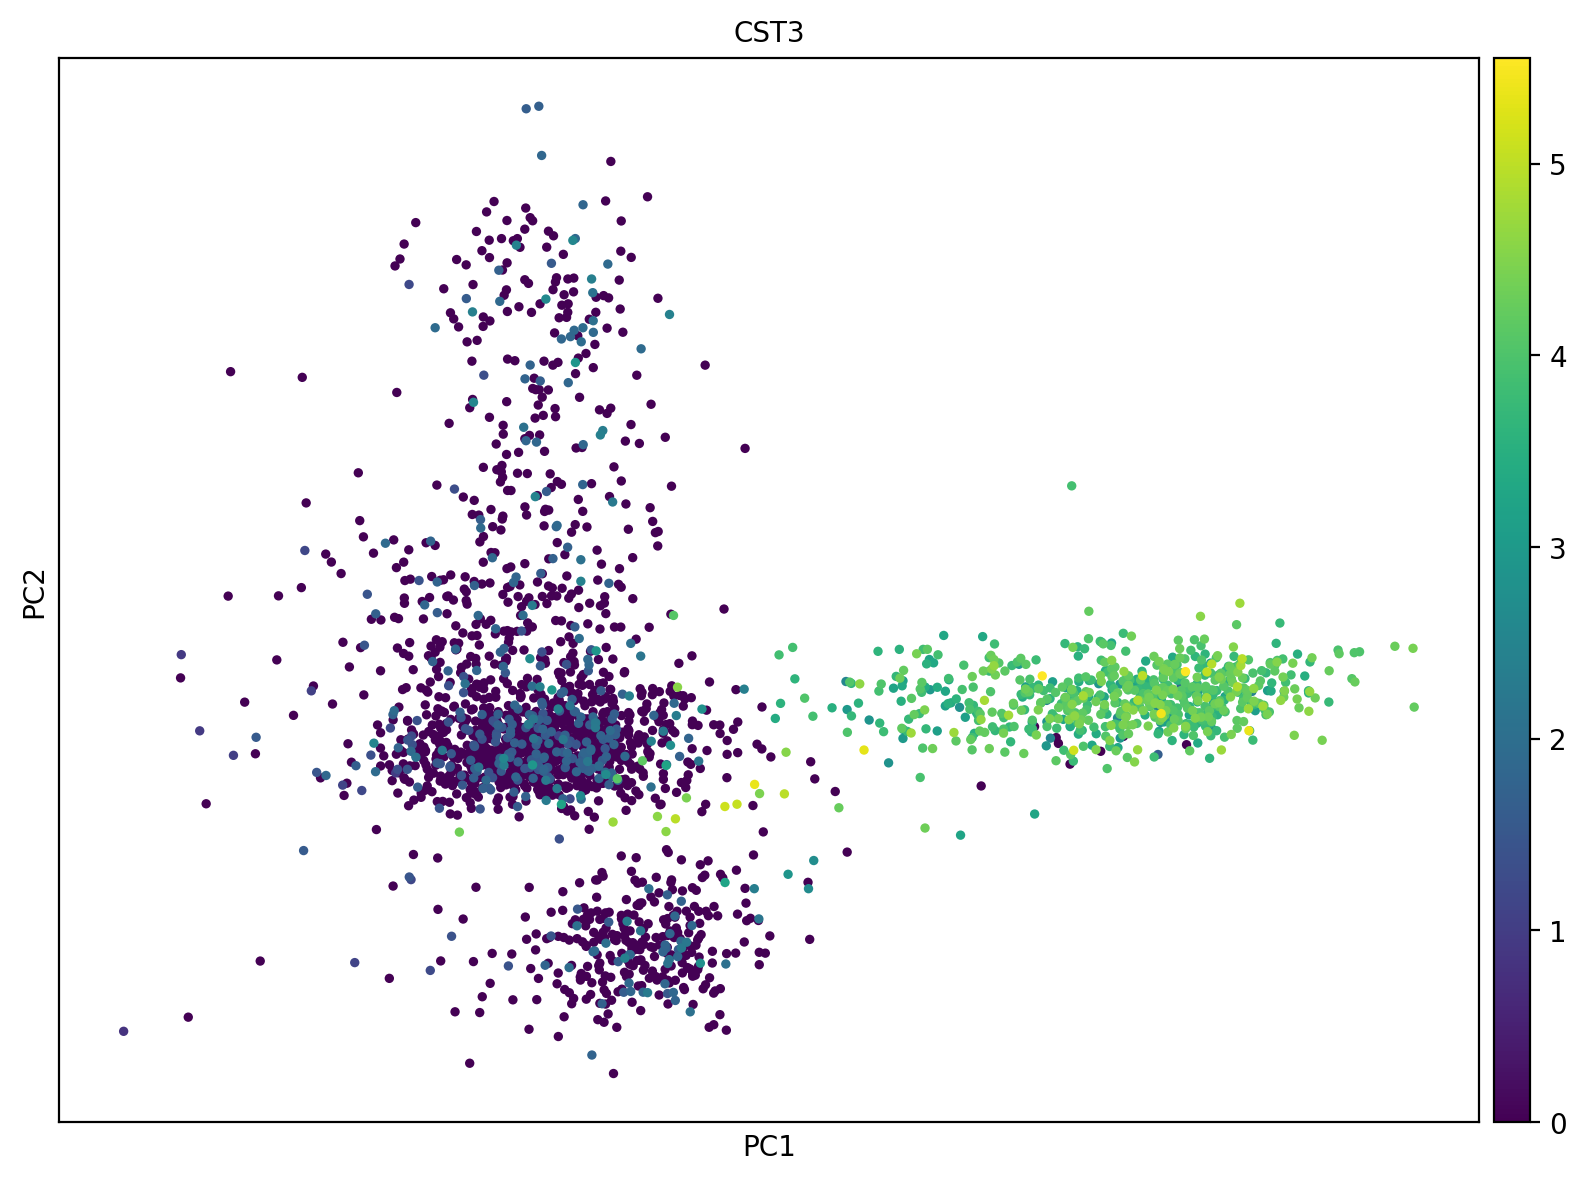

In [ ]:
# 完成主成分分析(principal component analysis, PCA)
# 通过运行主成分分析 (PCA) 来降低数据的维数，可以对数据进行去噪并揭示不同分群的主因素
sc.tl.pca(adata, svd_solver='arpack')

# 可视化：
sc.pl.pca(adata, color='CST3')

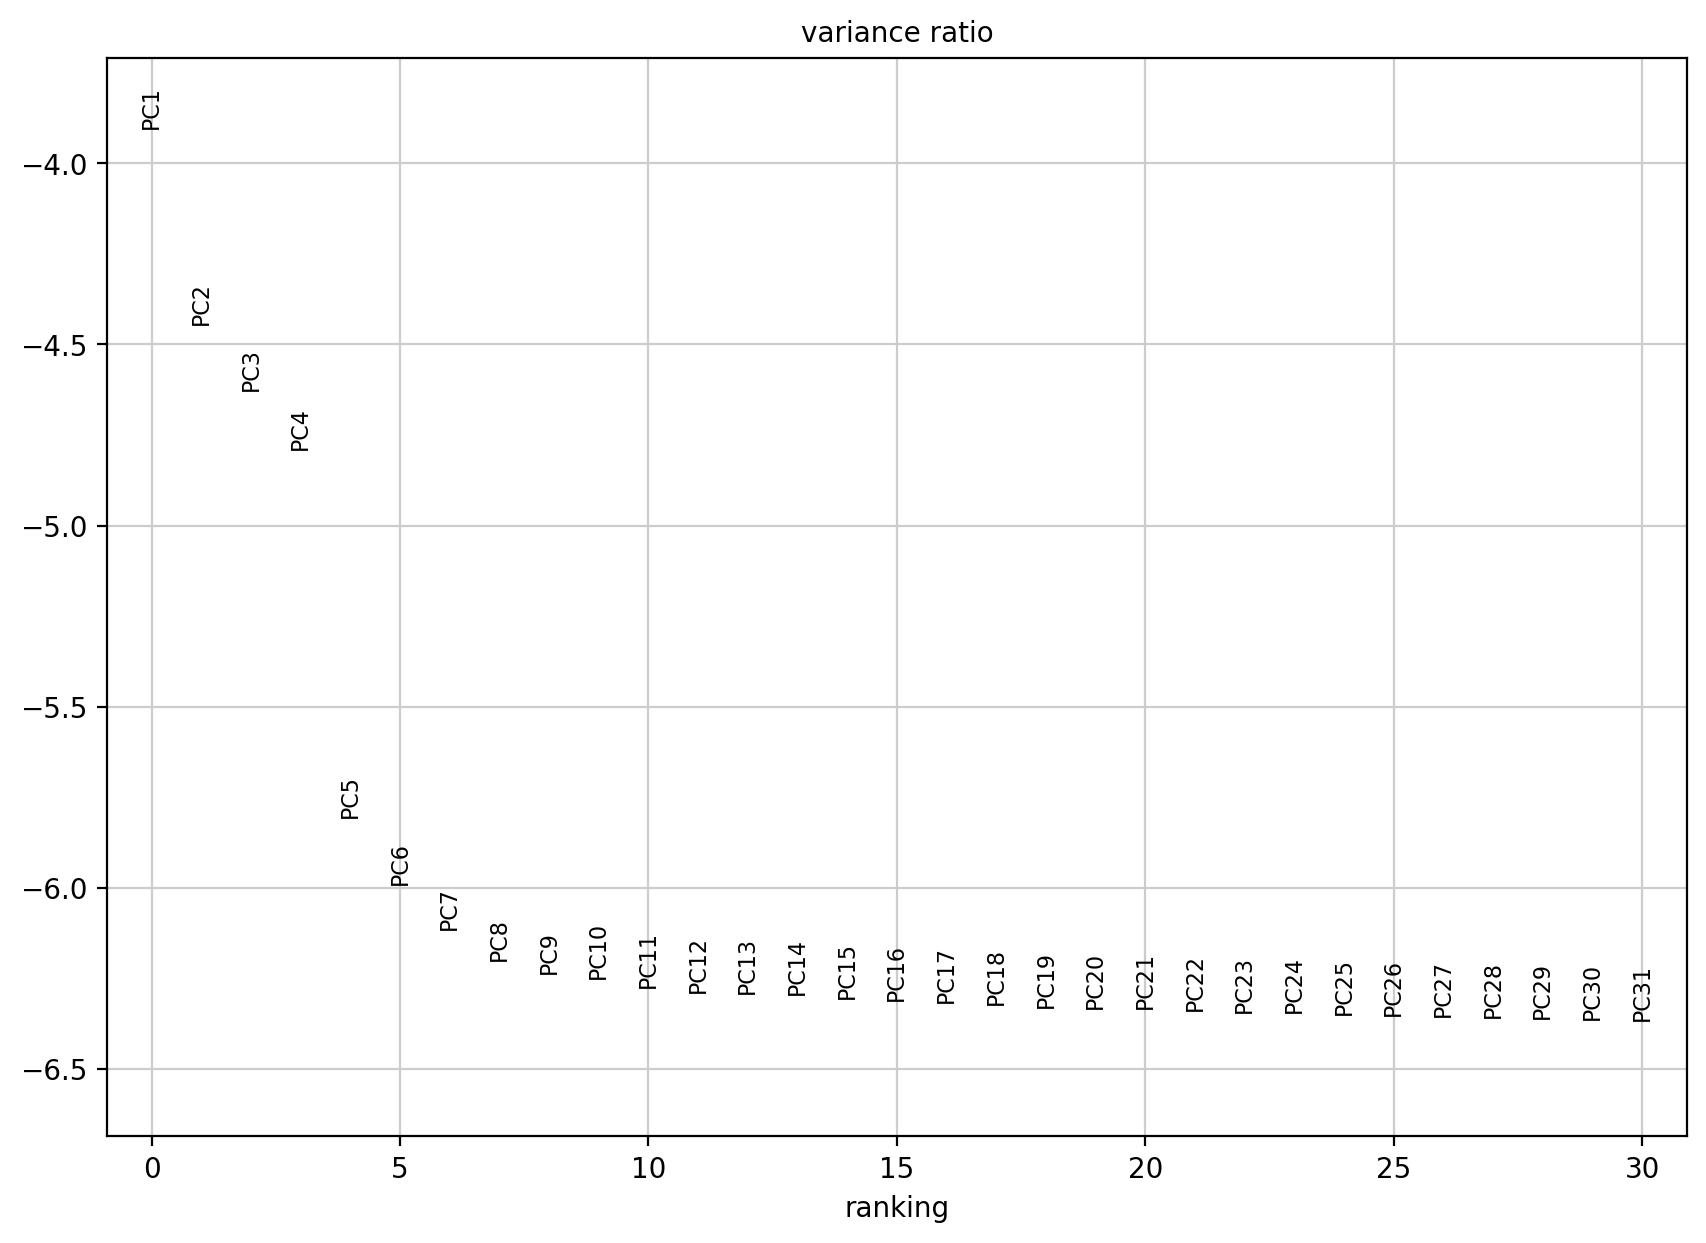

In [ ]:
# 检查单个 PC 对数据总方差的贡献，这可以提供给我们应该考虑多少个 PC 以计算细胞的邻域关系的信息，例如用于后续的聚类函数 sc.tl.louvain() 或 tSNE 聚类 sc.tl.tsne()。
# 计算每个PC对于数据方差的贡献度，决定了下游用于降维、聚类的PC数量：
# 类似于Seurat中的ElbowPlot
sc.pl.pca_variance_ratio(adata, log=True)

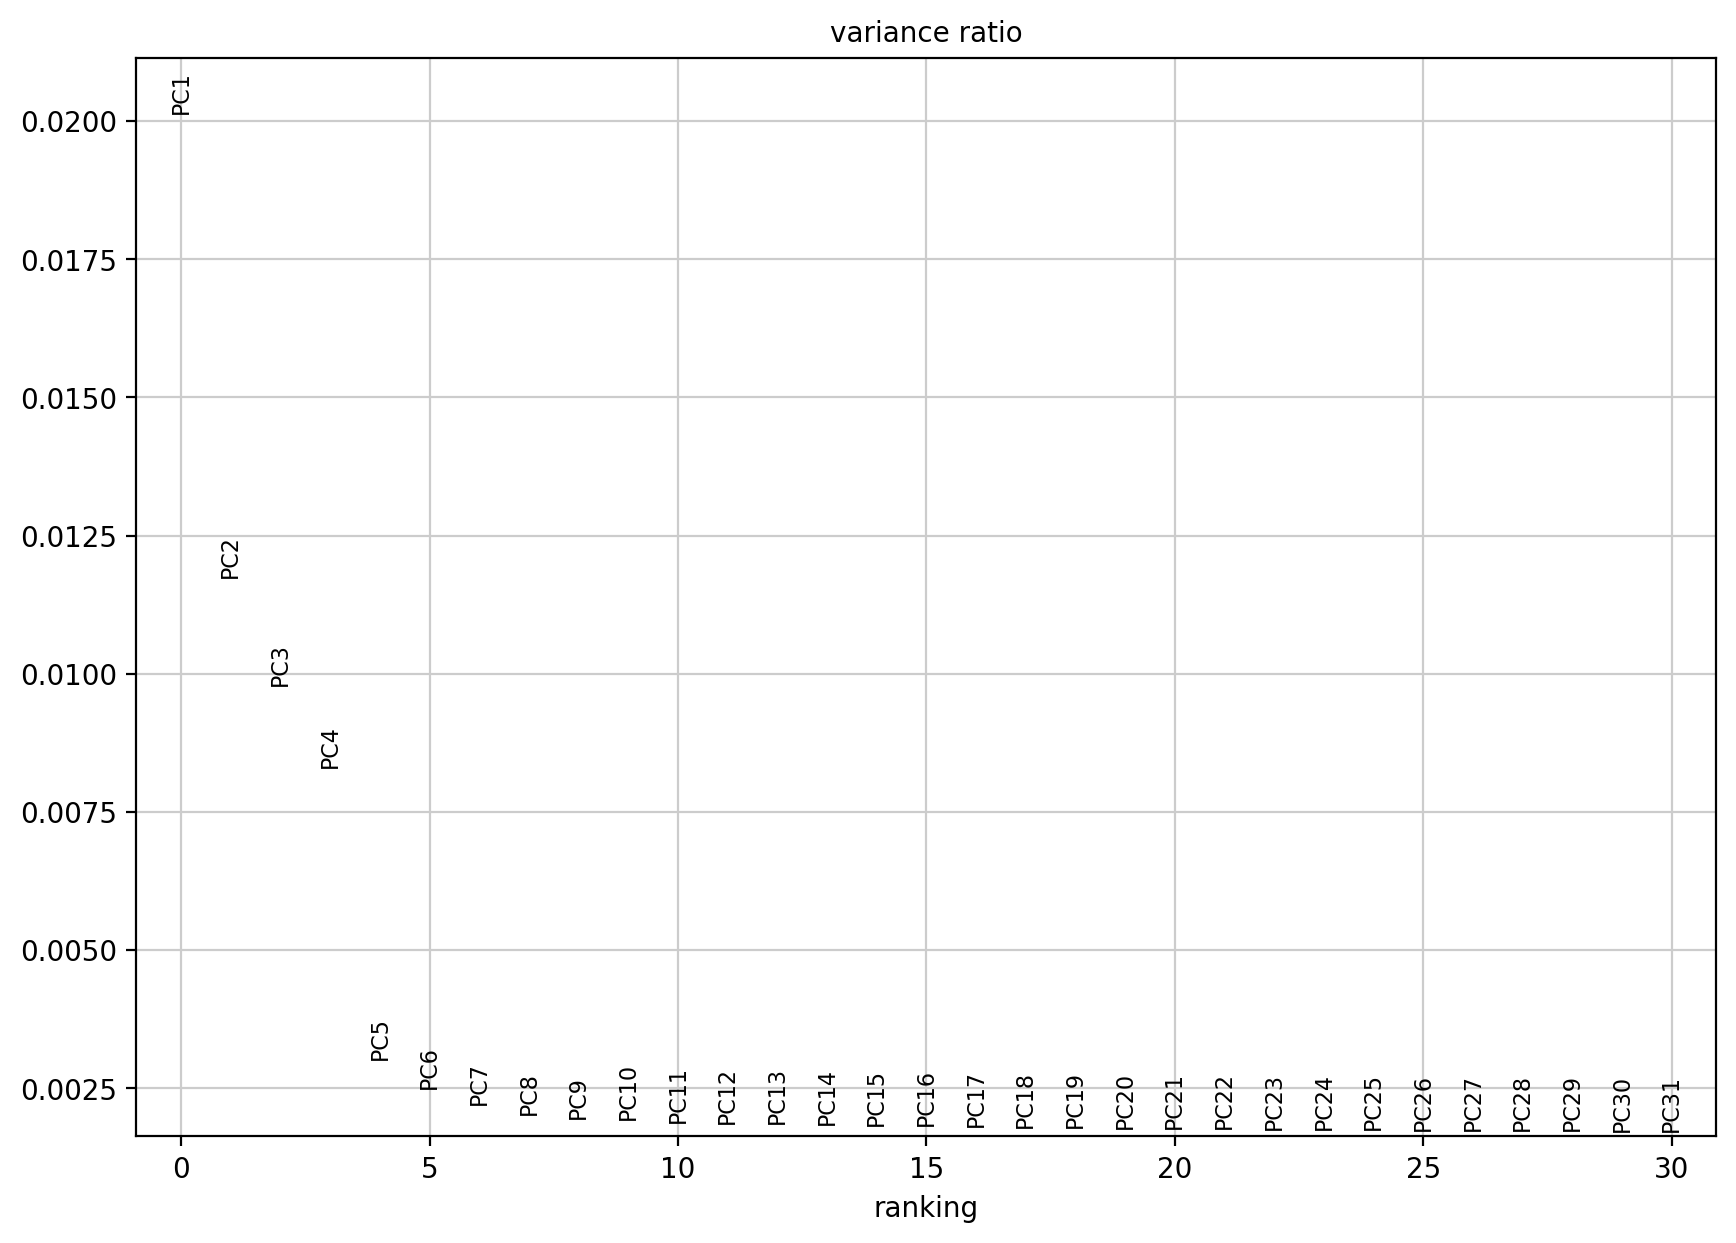

In [40]:
sc.pl.pca_variance_ratio(adata, log=False)

In [ ]:
# 细胞分群
# 利用PCA代表矩阵计算neighborhood graph，
# n_neighbors可以根据上图中变平缓的转折点选取，一般在10~20之间：
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


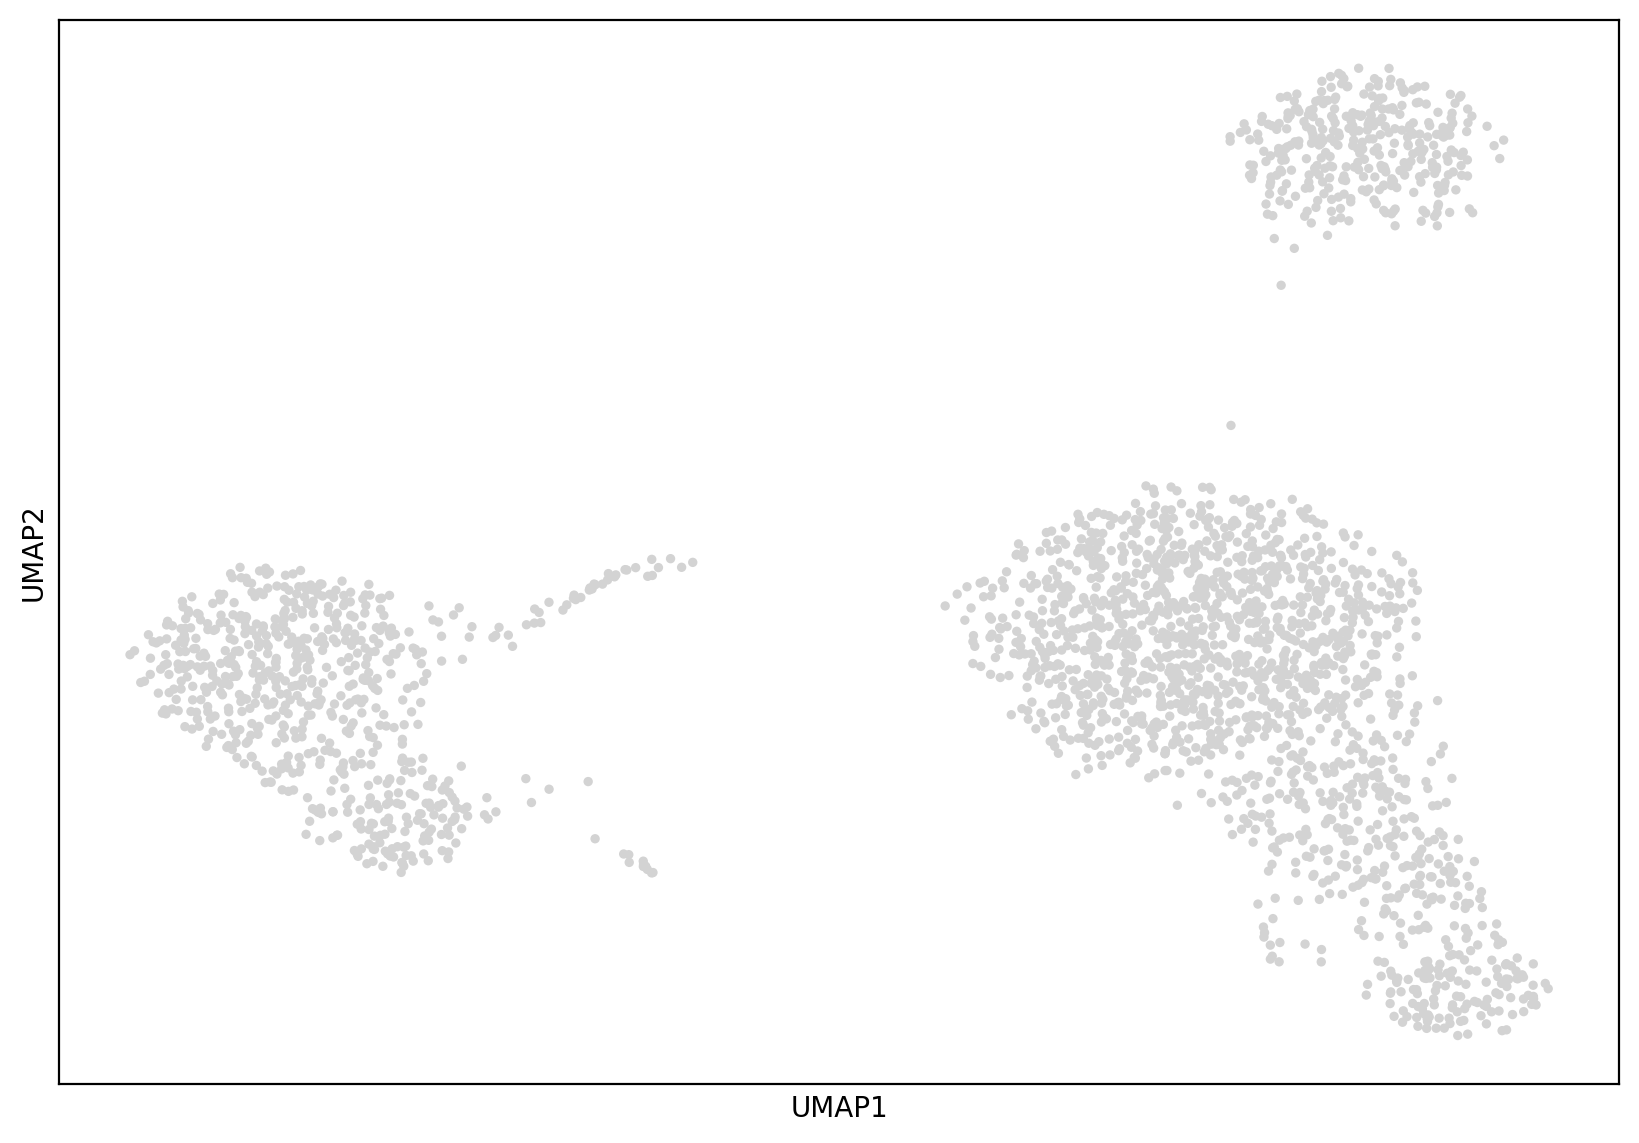

In [ ]:
# 在两种降维方法种，作者更倾向于umap：建议使用 UMAP ，它可能比 tSNE 更忠实于流形的全局连通性，因此能更好地保留轨迹
sc.tl.umap(adata)

# 查看降维结果
sc.pl.umap(adata)

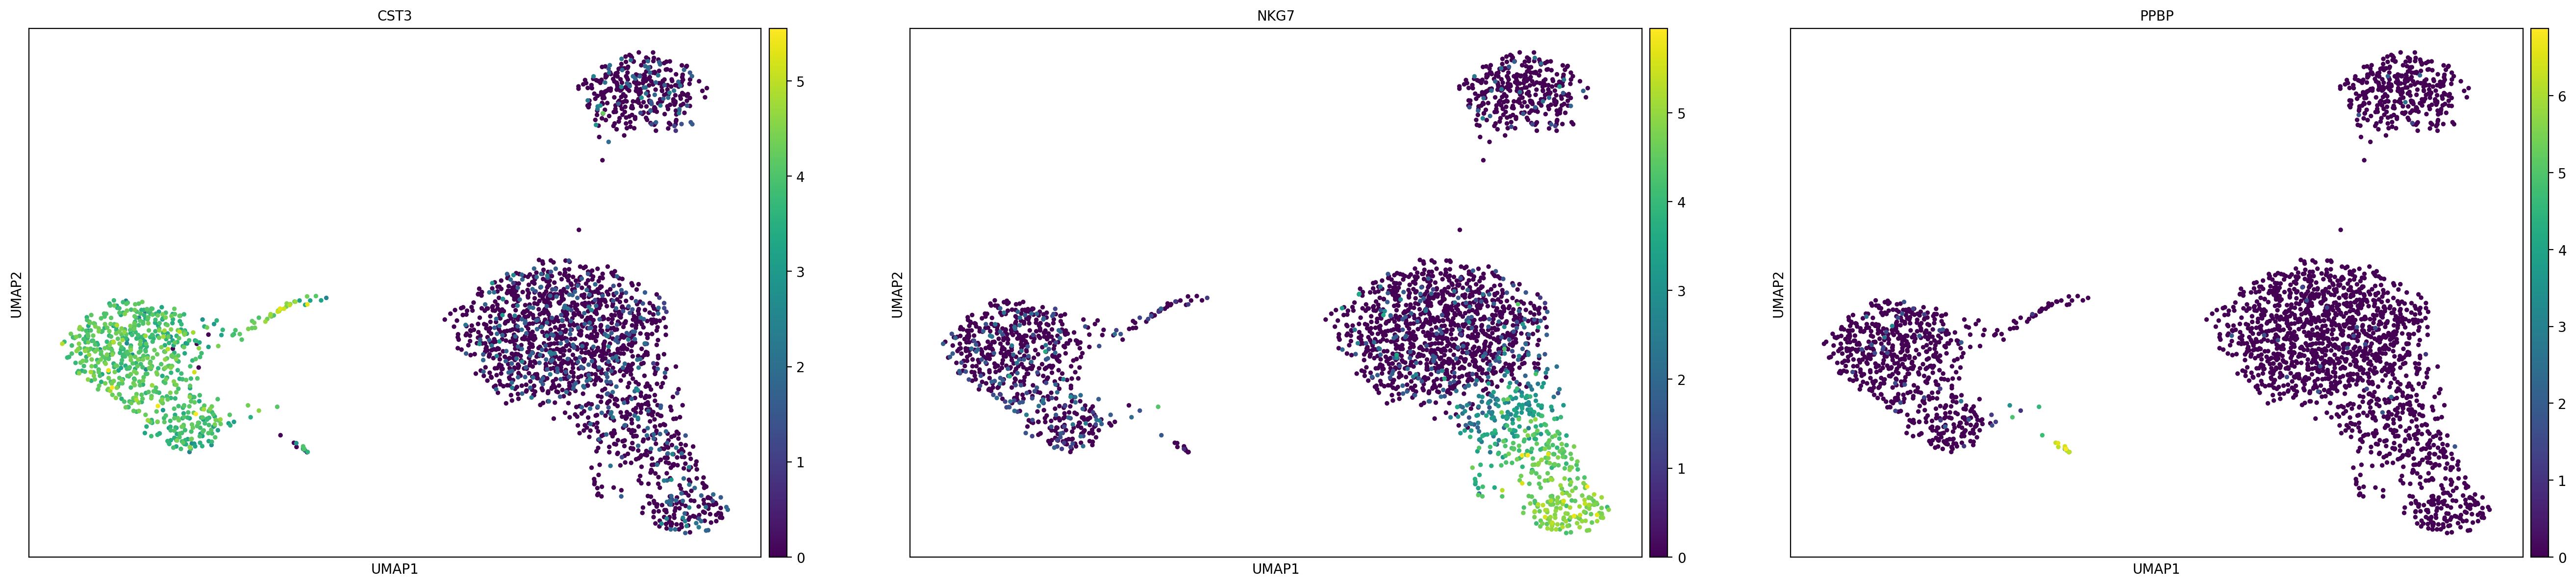

In [ ]:
# 可以直接在umap的结果上绘制基因表达量，类似于Seurat中的FeaturePlot
#  如果设置了 adata 的 .raw 属性时，下图显示了“raw”（标准化、对数化但未校正）基因表达矩阵
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

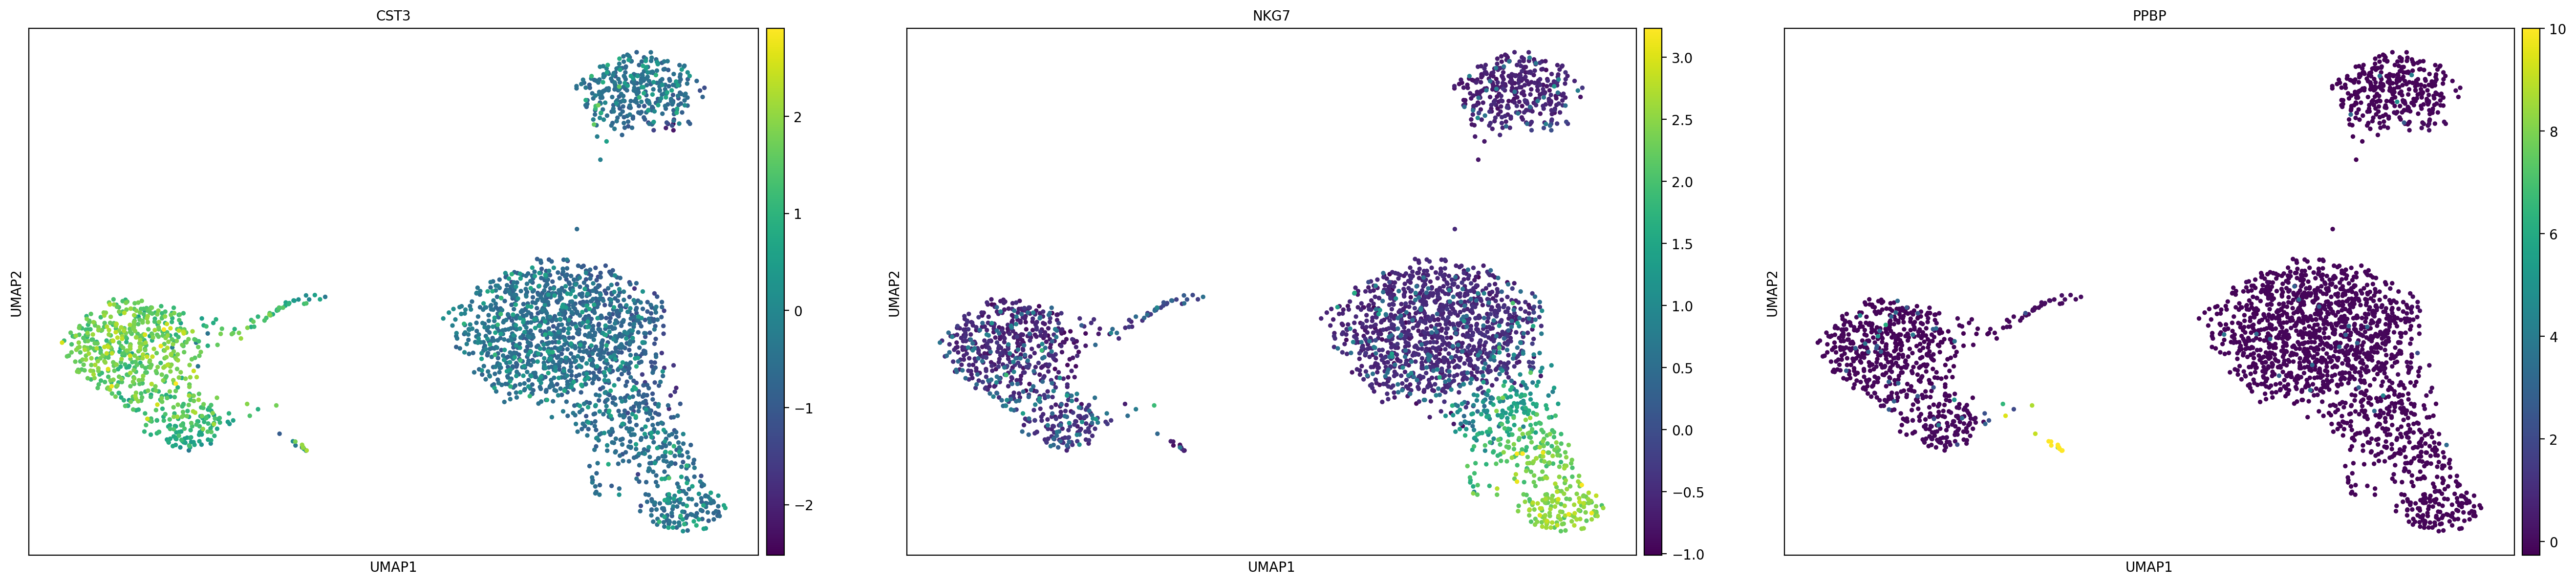

In [ ]:
# 当你想回溯上一个代码框的原始数据版时：
# 为了绘制缩放矫正的基因表达聚类图，需要使用 use_raw=False 参数。
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

In [ ]:
# 目前还没有计算出各个细胞类群，下面进行聚类

# 分群，这里作者推荐的是Leiden graph-clustering方法：Leiden 图聚类
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/tmp/ipykernel_986980/2386482808.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [55]:
sc.tl.leiden(adata,flavor="igraph",n_iterations=2,directed=False)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [58]:
adata.obs

n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1      781                779        2419.0             73.0   
AAACATTGAGCTAC-1     1352               1352        4903.0            186.0   
AAACATTGATCAGC-1     1131               1129        3147.0             28.0   
AAACCGTGCTTCCG-1      960                960        2639.0             46.0   
AAACCGTGTATGCG-1      522                521         980.0             12.0   
...                   ...                ...           ...              ...   
TTTCGAACTCTCAT-1     1155               1153        3459.0             73.0   
TTTCTACTGAGGCA-1     1227               1224        3443.0             32.0   
TTTCTACTTCCTCG-1      622                622        1684.0             37.0   
TTTGCATGAGAGGC-1      454                452        1022.0             21.0   
TTTGCATGCCTCAC-1      724                723        1984.0             16.0   

                  pct_counts_mt leiden  
AAACATACAACCAC-1       3.017776      0  
AAACATTGAGCTAC-1       3.793596      1  
AAACATTGATCAGC-1       0.889736      0  
AAACCGTGCTTCCG-1       1.743085      2  
AAACCGTGTATGCG-1       1.224490      3  
...                         ...    ...  
TTTCGAACTCTCAT-1       2.110436      5  
TTTCTACTGAGGCA-1       0.929422      1  
TTTCTACTTCCTCG-1       2.197150      1  
TTTGCATGAGAGGC-1       2.054795      1  
TTTGCATGCCTCAC-1       0.806452      0  

[2638 rows x 6 columns]

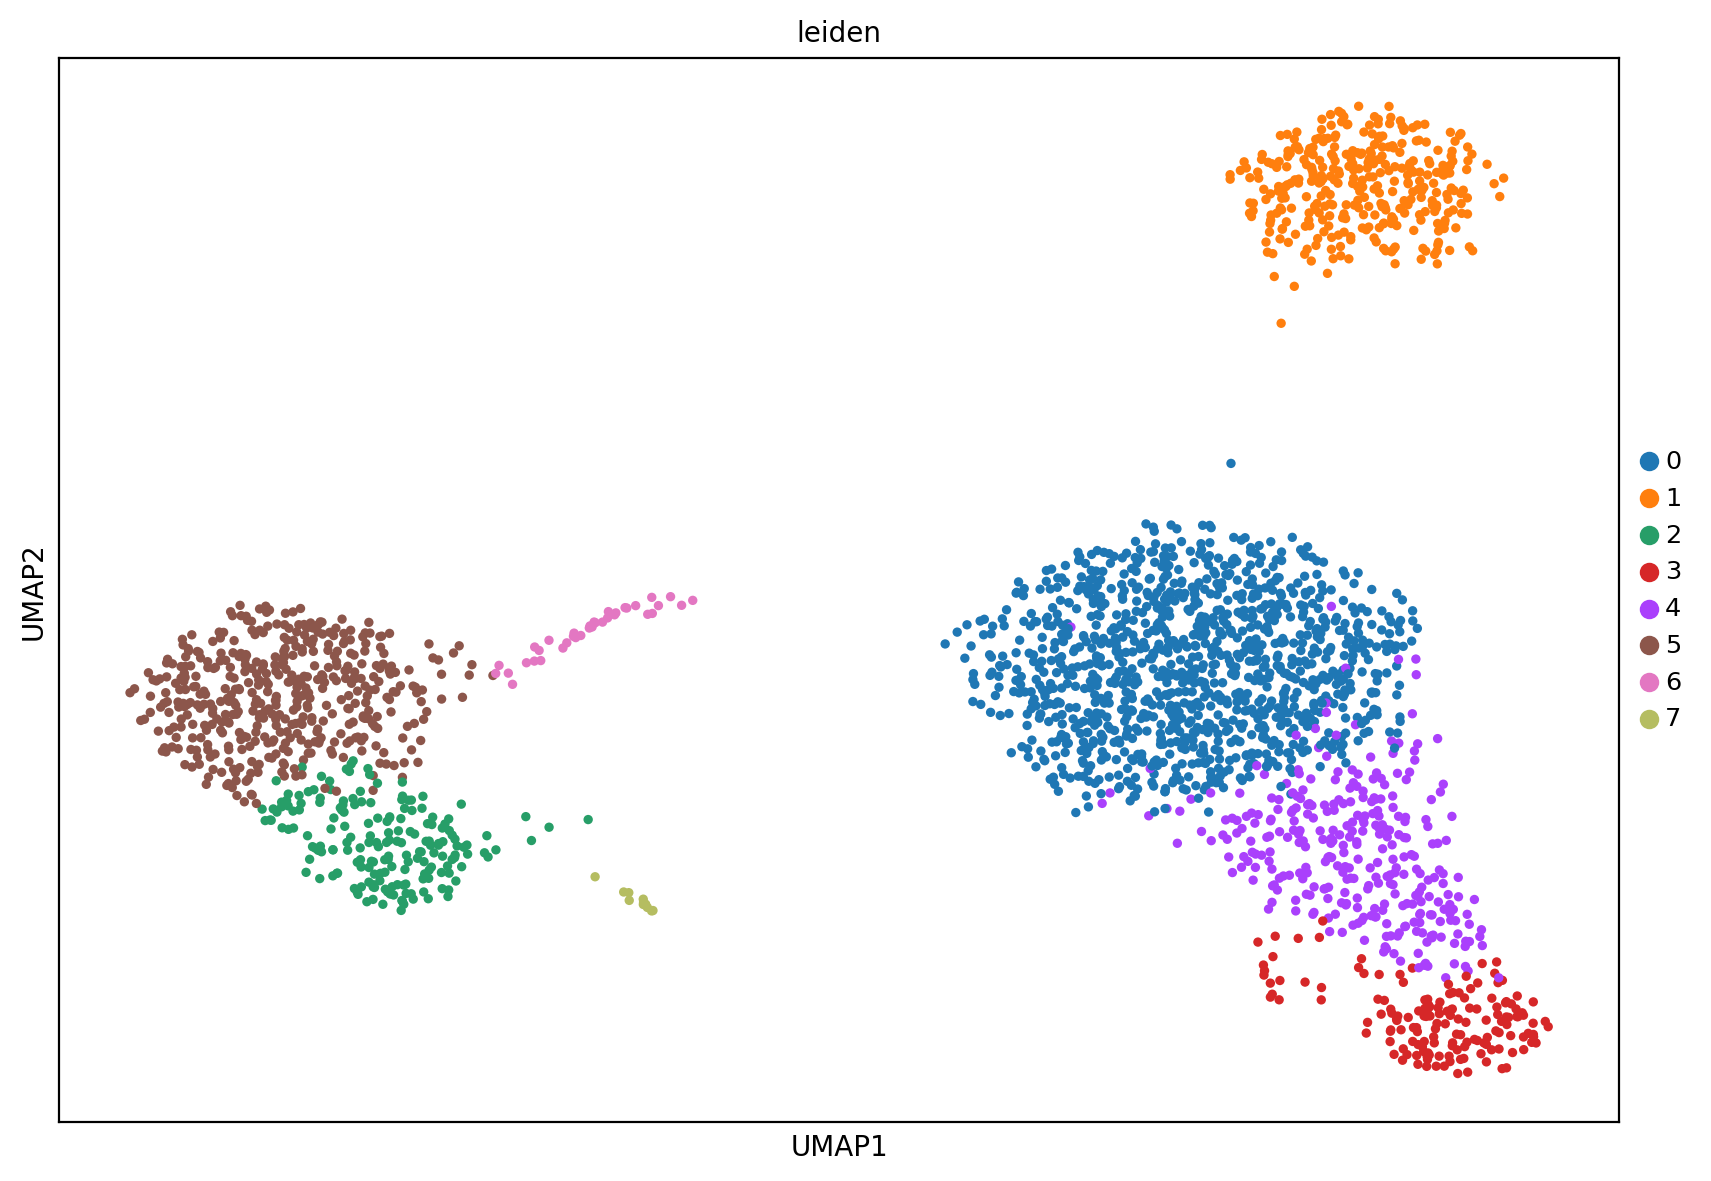

In [56]:
# 一共分为了八个亚群
sc.pl.umap(adata, color=['leiden'])

In [59]:
# 检索生物学标记基因
# 先计算每个 leiden 分群中高度差异基因的排名，取排名前 25 的基因。默认情况下，使用 AnnData 的 .raw 属性。

# 为marker基因的计算做ranking，最快的是t检验：最简单和最快的方法是 t 检验
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


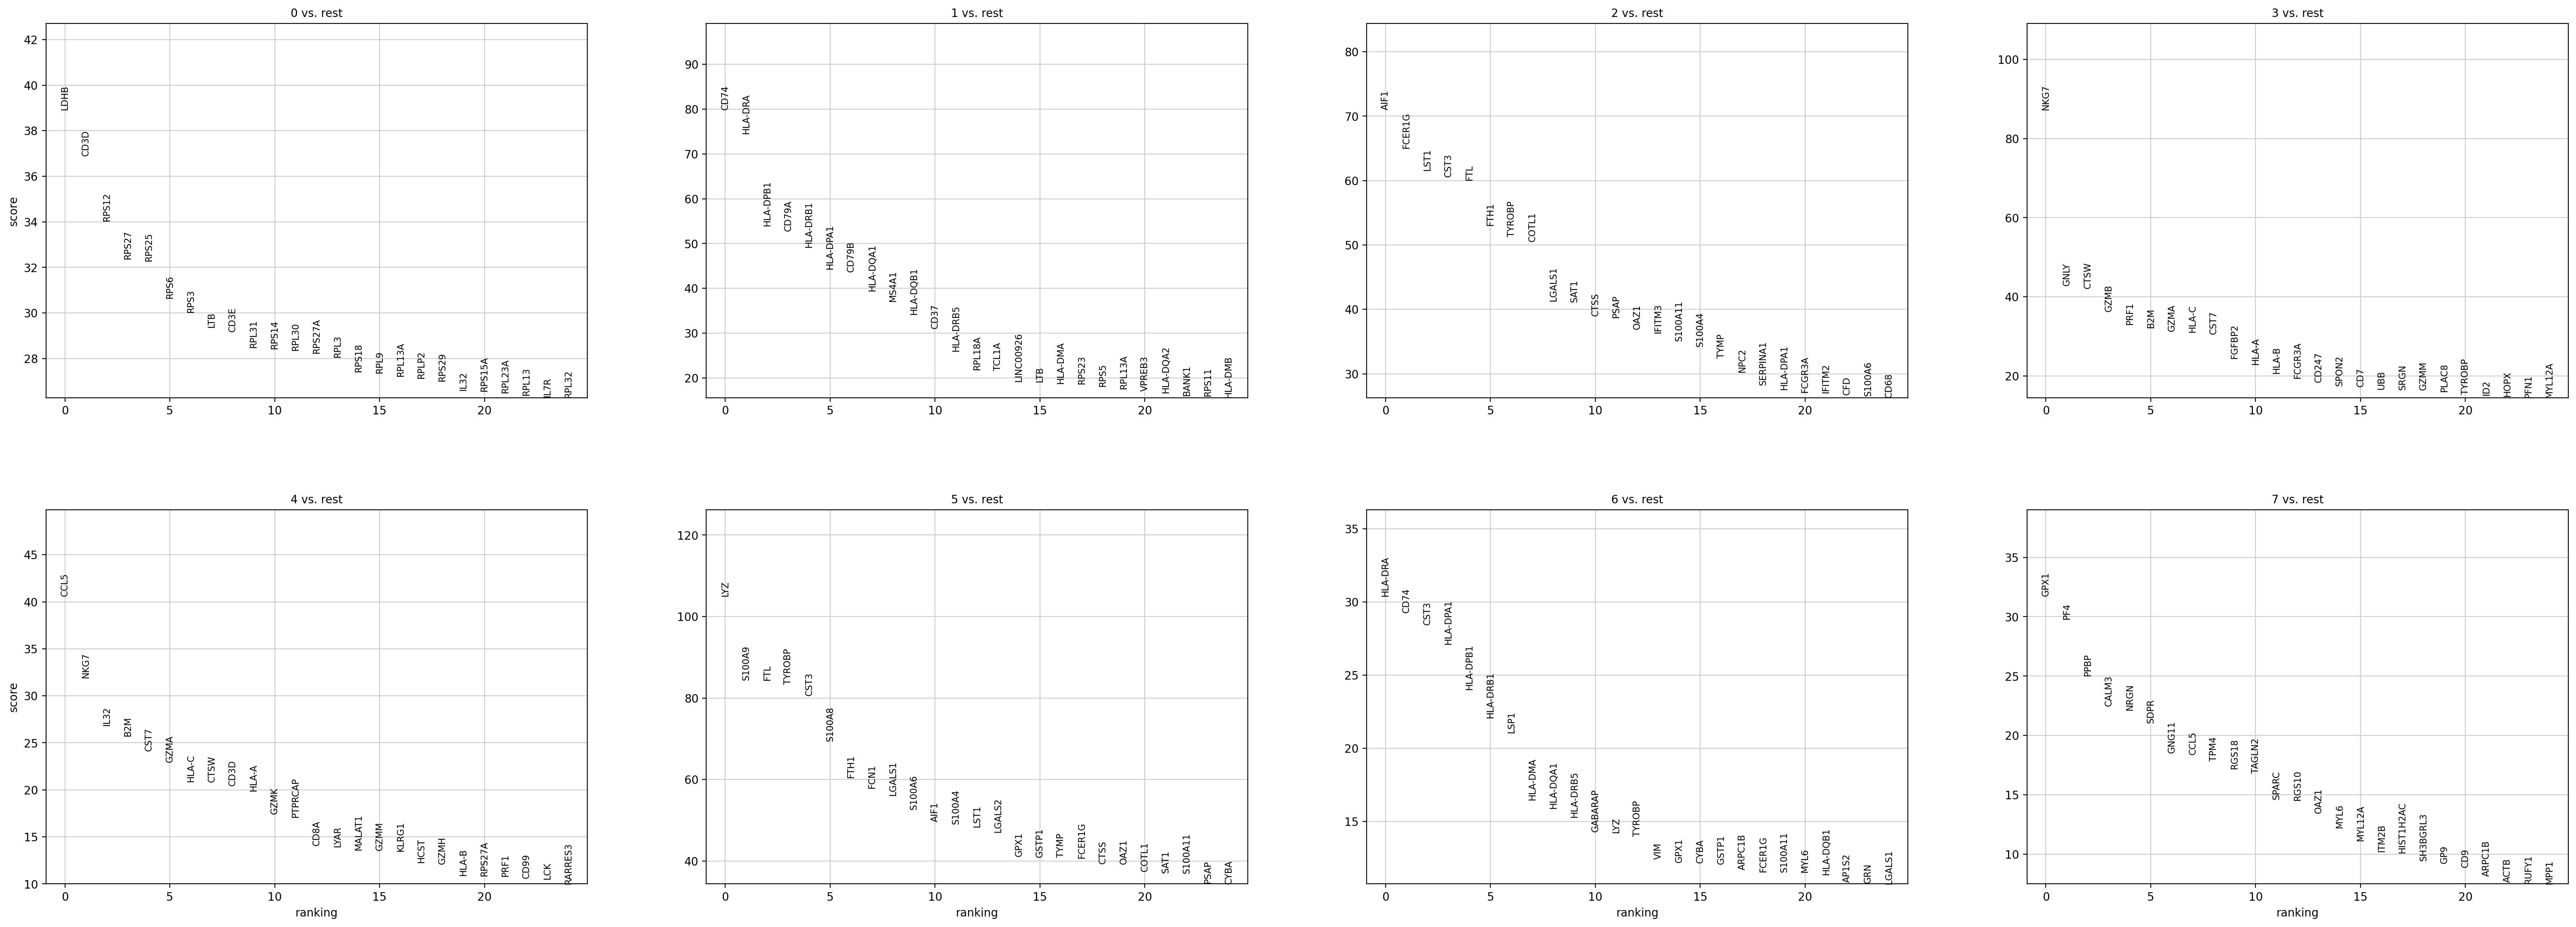

In [62]:
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


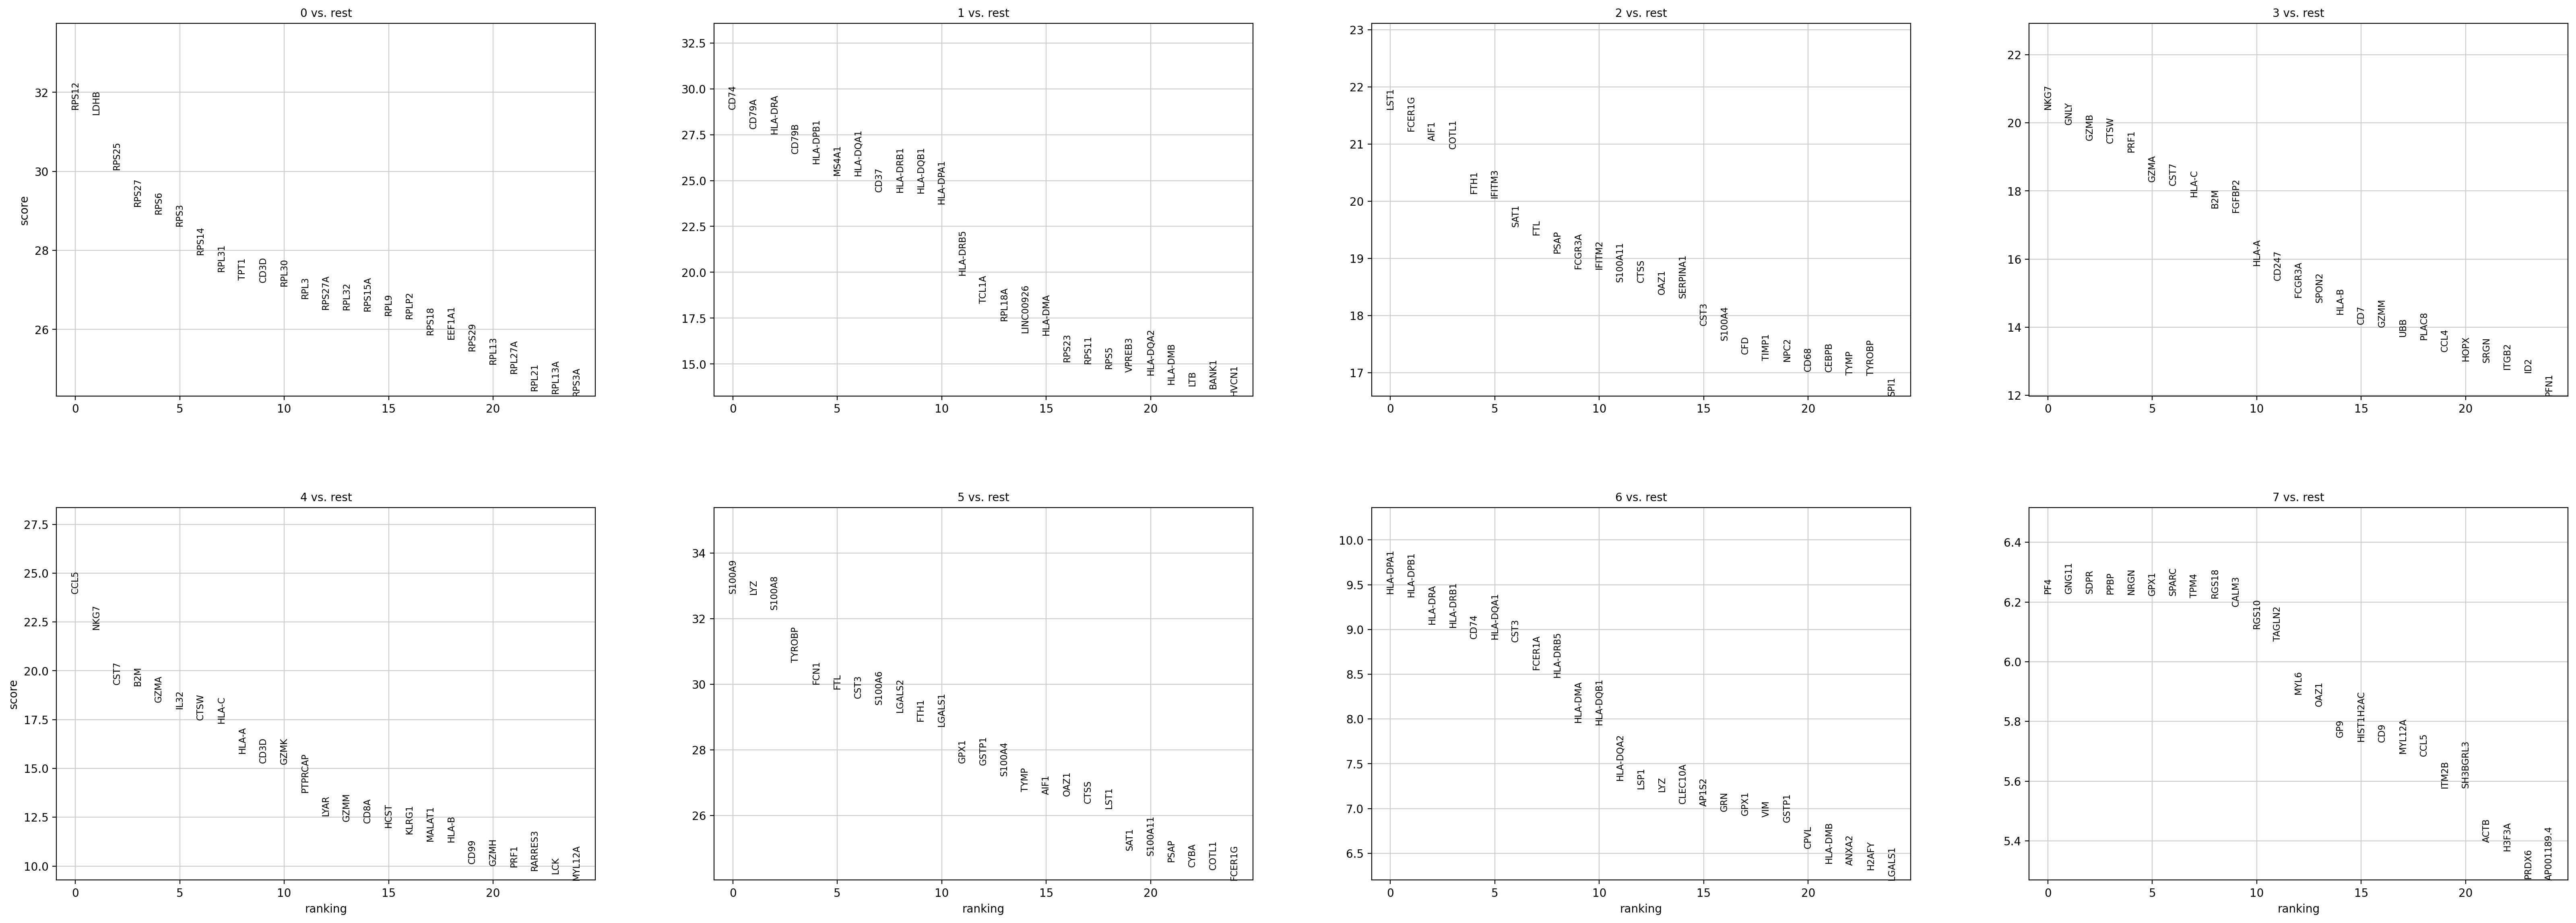

In [ ]:
#  Wilcoxon rank-sum 是作者最推荐的方式，此外还有MAST, limma, DESeq2, diffxpy, logreg等方式 
# Wilcoxon rank-sum (Mann-Whitney-U) 检验的结果非常相似，还可以使用其他的差异分析包，如 MAST、limma、DESeq2 和 diffxpy
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# 保存这次的数据结果，可用于后续载入数据
adata.write(results_file)

# 载入数据
# 使用 Wilcoxon Rank-Sum 测试结果重新加载已保存的对象
adata = sc.read(results_file)

In [ ]:
# 逻辑回归
# 使用逻辑回归对基因进行排名 Natranos et al. (2018)，这里使用多变量方法，而传统的差异测试是单变量 Clark et al. (2014)
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [72]:
adata.uns['rank_genes_groups']
# print(pd.DataFrame(adata.uns['rank_genes_groups']["names"]))
pd.DataFrame(adata.uns['rank_genes_groups']["names"])

0         1       2       3         4       5         6       7
0         RPS12      CD74    LST1    NKG7      CCL5  S100A9  HLA-DPA1     PF4
1          LDHB     CD79A  FCER1G    GNLY      NKG7     LYZ  HLA-DPB1   GNG11
2         RPS25   HLA-DRA    AIF1    GZMB      CST7  S100A8   HLA-DRA    SDPR
3         RPS27     CD79B   COTL1    CTSW       B2M  TYROBP  HLA-DRB1    PPBP
4          RPS6  HLA-DPB1    FTH1    PRF1      GZMA    FCN1      CD74    NRGN
...         ...       ...     ...     ...       ...     ...       ...     ...
13709  HLA-DPA1      IL32   RPS18   RPS12  C1orf162    RPSA       B2M    RPL3
13710  HLA-DRB1     ANXA1    RPS3   RPL11   HLA-DRA  RPL23A      BTG1   RPL29
13711   HLA-DRA    S100A6  RPL13A   RPL28     RPS11   RPS27     RPL21   RPL11
13712      CYBA    TMSB4X   RPL13  RPL18A      FTH1  RPS27A     RPS27  MALAT1
13713      CD74    S100A4    RPL3   RPL32    TMSB10  MALAT1    MALAT1   RPL10

[13714 rows x 8 columns]

In [71]:
# 这是刚才计算出的每个cluster的top5的marker gene
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1       2     3     4       5         6      7
0  RPS12      CD74    LST1  NKG7  CCL5  S100A9  HLA-DPA1    PF4
1   LDHB     CD79A  FCER1G  GNLY  NKG7     LYZ  HLA-DPB1  GNG11
2  RPS25   HLA-DRA    AIF1  GZMB  CST7  S100A8   HLA-DRA   SDPR
3  RPS27     CD79B   COTL1  CTSW   B2M  TYROBP  HLA-DRB1   PPBP
4   RPS6  HLA-DPB1    FTH1  PRF1  GZMA    FCN1      CD74   NRGN

In [78]:
# 查看这些marker在所属cluster中得到的分值：
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names #分组名称，实际上就是簇名cluster
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p       1_n            1_p     2_n            2_p   3_n  \
0  RPS12  1.073968e-218      CD74  2.487145e-183    LST1  1.622110e-103  NKG7   
1   LDHB  6.824116e-217     CD79A  1.679730e-170  FCER1G  5.878996e-100  GNLY   
2  RPS25  2.590427e-198   HLA-DRA  6.935111e-167    AIF1   2.002411e-98  GZMB   
3  RPS27  2.655618e-186     CD79B  2.569135e-154   COTL1   3.853307e-97  CTSW   
4   RPS6  7.065525e-184  HLA-DPB1  3.577195e-148    FTH1   3.651643e-90  PRF1   

            3_p   4_n            4_p     5_n            5_p       6_n  \
0  1.923512e-92  CCL5  8.987472e-127  S100A9  1.938302e-235  HLA-DPA1   
1  1.513503e-88  NKG7  2.407704e-108     LYZ  3.649395e-235  HLA-DPB1   
2  1.405777e-84  CST7   6.220247e-83  S100A8  1.662202e-228   HLA-DRA   
3  7.510027e-84   B2M   2.488941e-82  TYROBP  1.653857e-206  HLA-DRB1   
4  1.053180e-81  GZMA   1.989132e-75    FCN1  1.114817e-197      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21  GNG11  4.733899e-10  
2  1.306768e-19   SDPR  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

In [79]:
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']})

0_n            0_p       1_n            1_p     2_n  \
0         RPS12  1.073968e-218      CD74  2.487145e-183    LST1   
1          LDHB  6.824116e-217     CD79A  1.679730e-170  FCER1G   
2         RPS25  2.590427e-198   HLA-DRA  6.935111e-167    AIF1   
3         RPS27  2.655618e-186     CD79B  2.569135e-154   COTL1   
4          RPS6  7.065525e-184  HLA-DPB1  3.577195e-148    FTH1   
...         ...            ...       ...            ...     ...   
13709  HLA-DPA1  2.631094e-164      IL32   3.590714e-62   RPS18   
13710  HLA-DRB1  6.348779e-178     ANXA1   2.872739e-64    RPS3   
13711   HLA-DRA  1.404364e-187    S100A6   7.845996e-83  RPL13A   
13712      CYBA  1.137387e-202    TMSB4X   1.666637e-95   RPL13   
13713      CD74  1.030467e-210    S100A4  1.235875e-109    RPL3   

                 2_p     3_n           3_p       4_n            4_p     5_n  \
0      1.622110e-103    NKG7  1.923512e-92      CCL5  8.987472e-127  S100A9   
1      5.878996e-100    GNLY  1.513503e-88      NKG7  2.407704e-108     LYZ   
2       2.002411e-98    GZMB  1.405777e-84      CST7   6.220247e-83  S100A8   
3       3.853307e-97    CTSW  7.510027e-84       B2M   2.488941e-82  TYROBP   
4       3.651643e-90    PRF1  1.053180e-81      GZMA   1.989132e-75    FCN1   
...              ...     ...           ...       ...            ...     ...   
13709   4.413304e-61   RPS12  2.049749e-48  C1orf162   3.995243e-22    RPSA   
13710   3.231241e-63   RPL11  9.211191e-50   HLA-DRA   9.282799e-24  RPL23A   
13711   5.319847e-65   RPL28  6.994417e-52     RPS11   4.836535e-24   RPS27   
13712   3.716137e-67  RPL18A  8.802245e-58      FTH1   9.975812e-25  RPS27A   
13713   1.382875e-69   RPL32  3.409912e-59    TMSB10   6.018552e-32  MALAT1   

                 5_p       6_n           6_p     7_n           7_p  
0      1.938302e-235  HLA-DPA1  5.422417e-21     PF4  4.722886e-10  
1      3.649395e-235  HLA-DPB1  7.591860e-21   GNG11  4.733899e-10  
2      1.662202e-228   HLA-DRA  1.306768e-19    SDPR  4.733899e-10  
3      1.653857e-206  HLA-DRB1  1.865104e-19    PPBP  4.744938e-10  
4      1.114817e-197      CD74  5.853161e-19    NRGN  4.800511e-10  
...              ...       ...           ...     ...           ...  
13709  2.661312e-131       B2M  2.354203e-08    RPL3  1.256160e-09  
13710  2.060479e-134      BTG1  1.259540e-08   RPL29  1.211256e-09  
13711  5.082931e-138     RPL21  7.289634e-09   RPL11  1.078322e-09  
13712  1.126725e-151     RPS27  1.384111e-09  MALAT1  8.918017e-10  
13713  7.375256e-187    MALAT1  3.970831e-13   RPL10  5.687968e-10  

[13714 rows x 16 columns]

/home/csn/program/miniconda3/envs/sc-python/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


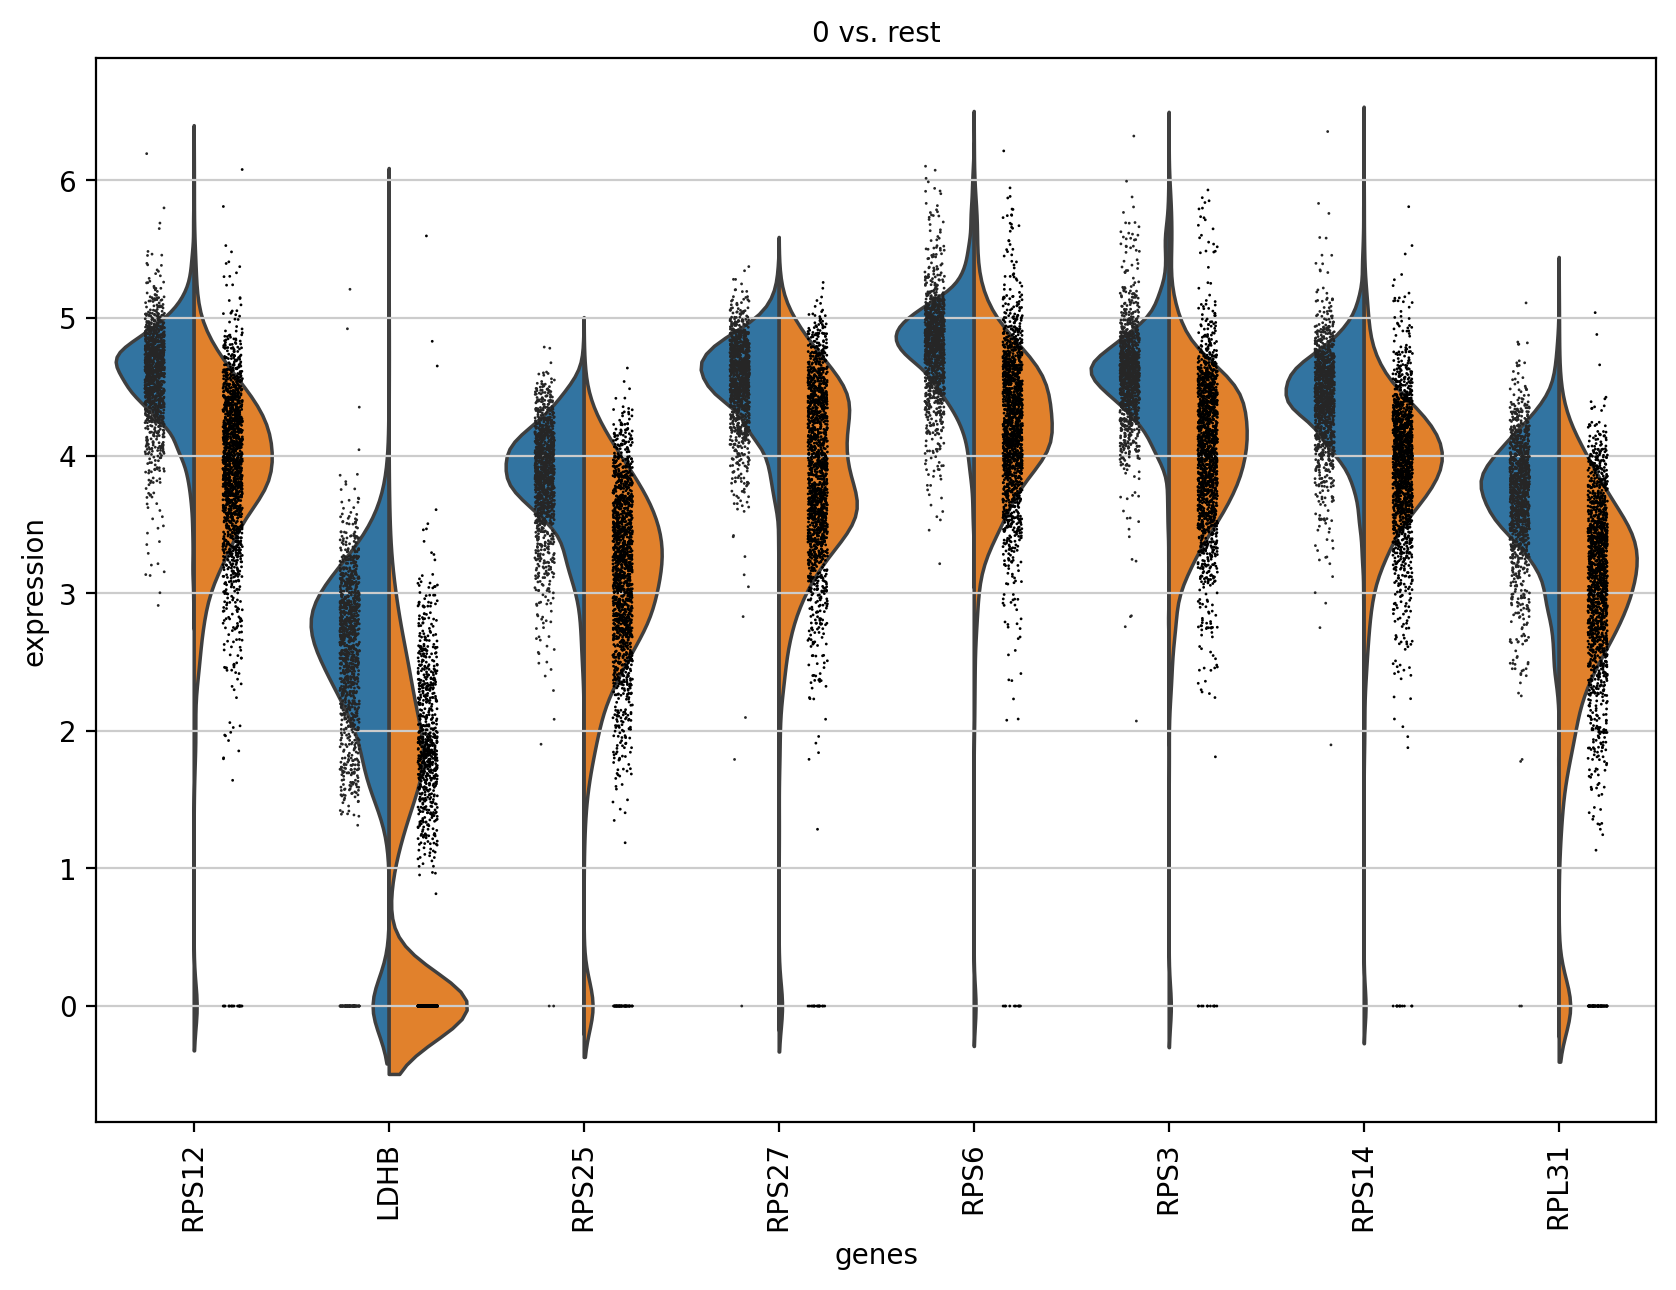

In [ ]:
# 画出cluster0的前八个marker基因
# Group 0 与其余组的比较进行差异分析
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


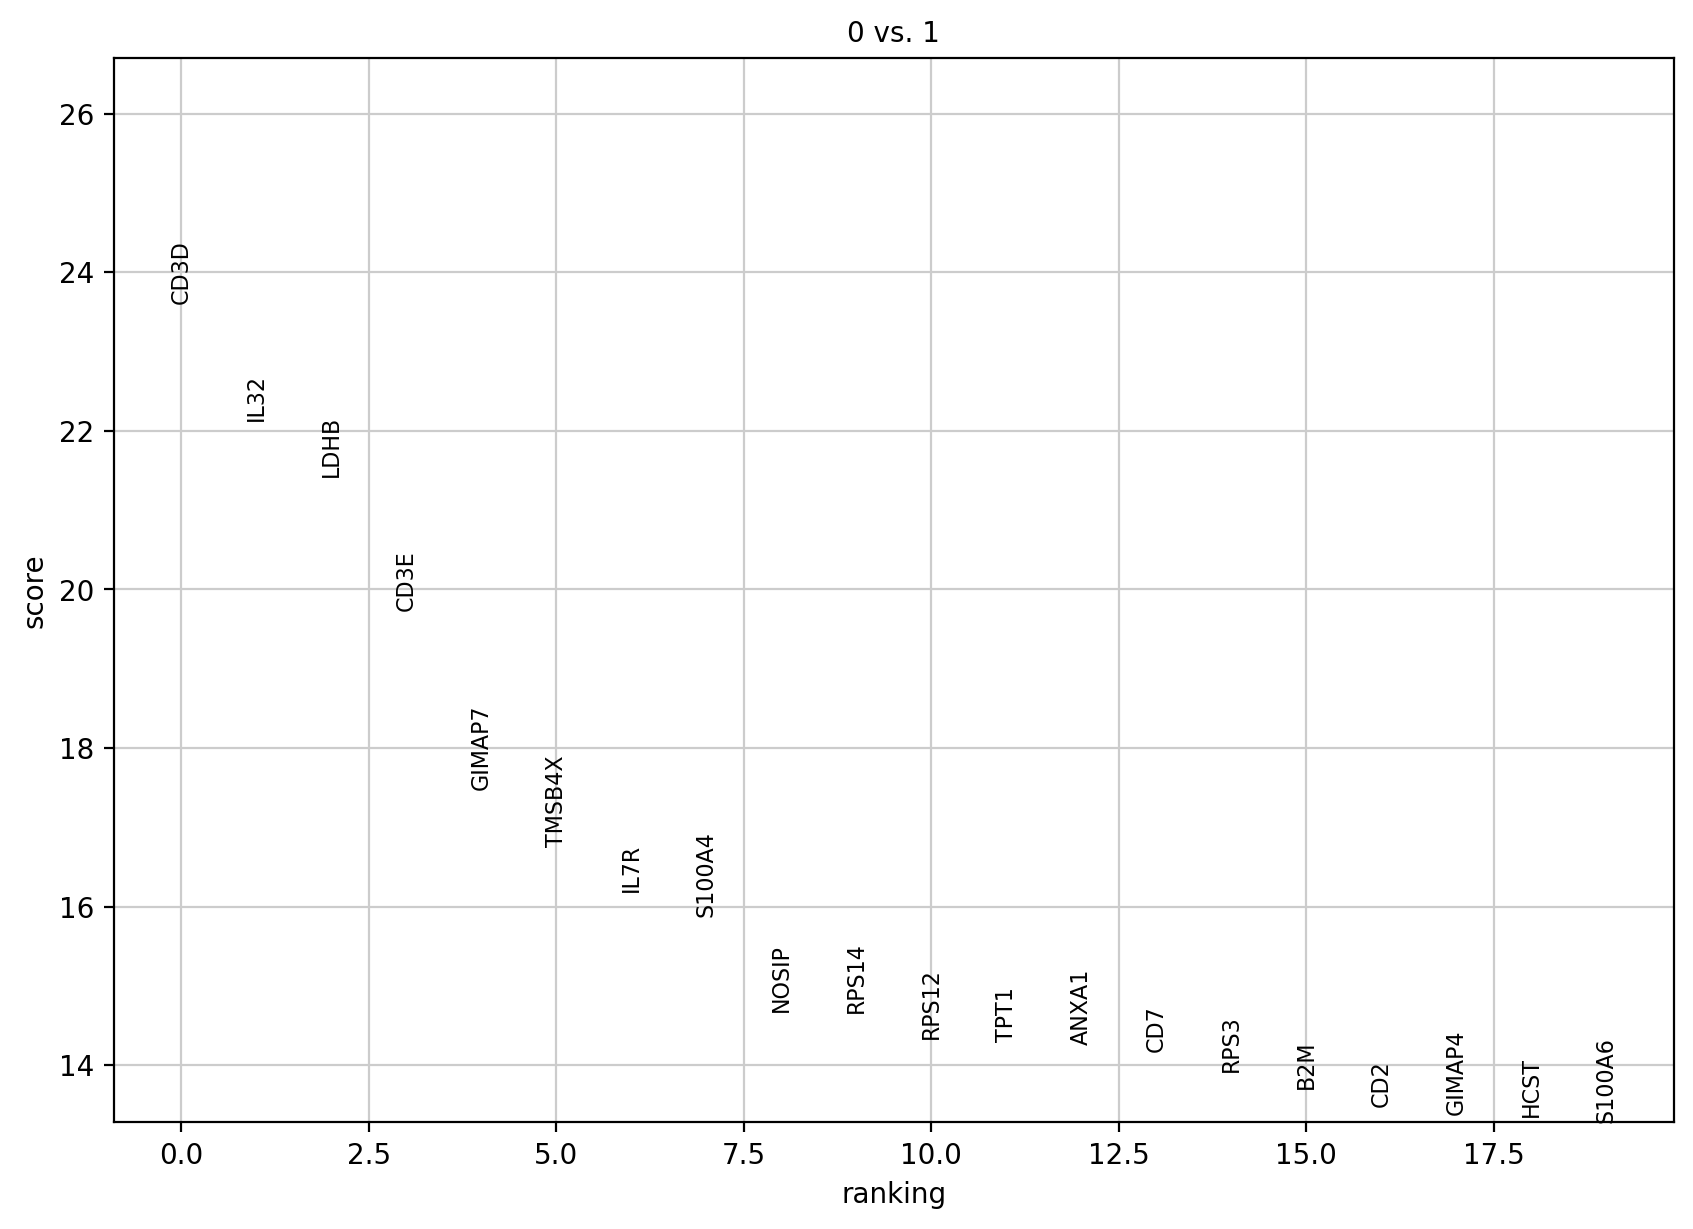

/home/csn/program/miniconda3/envs/sc-python/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


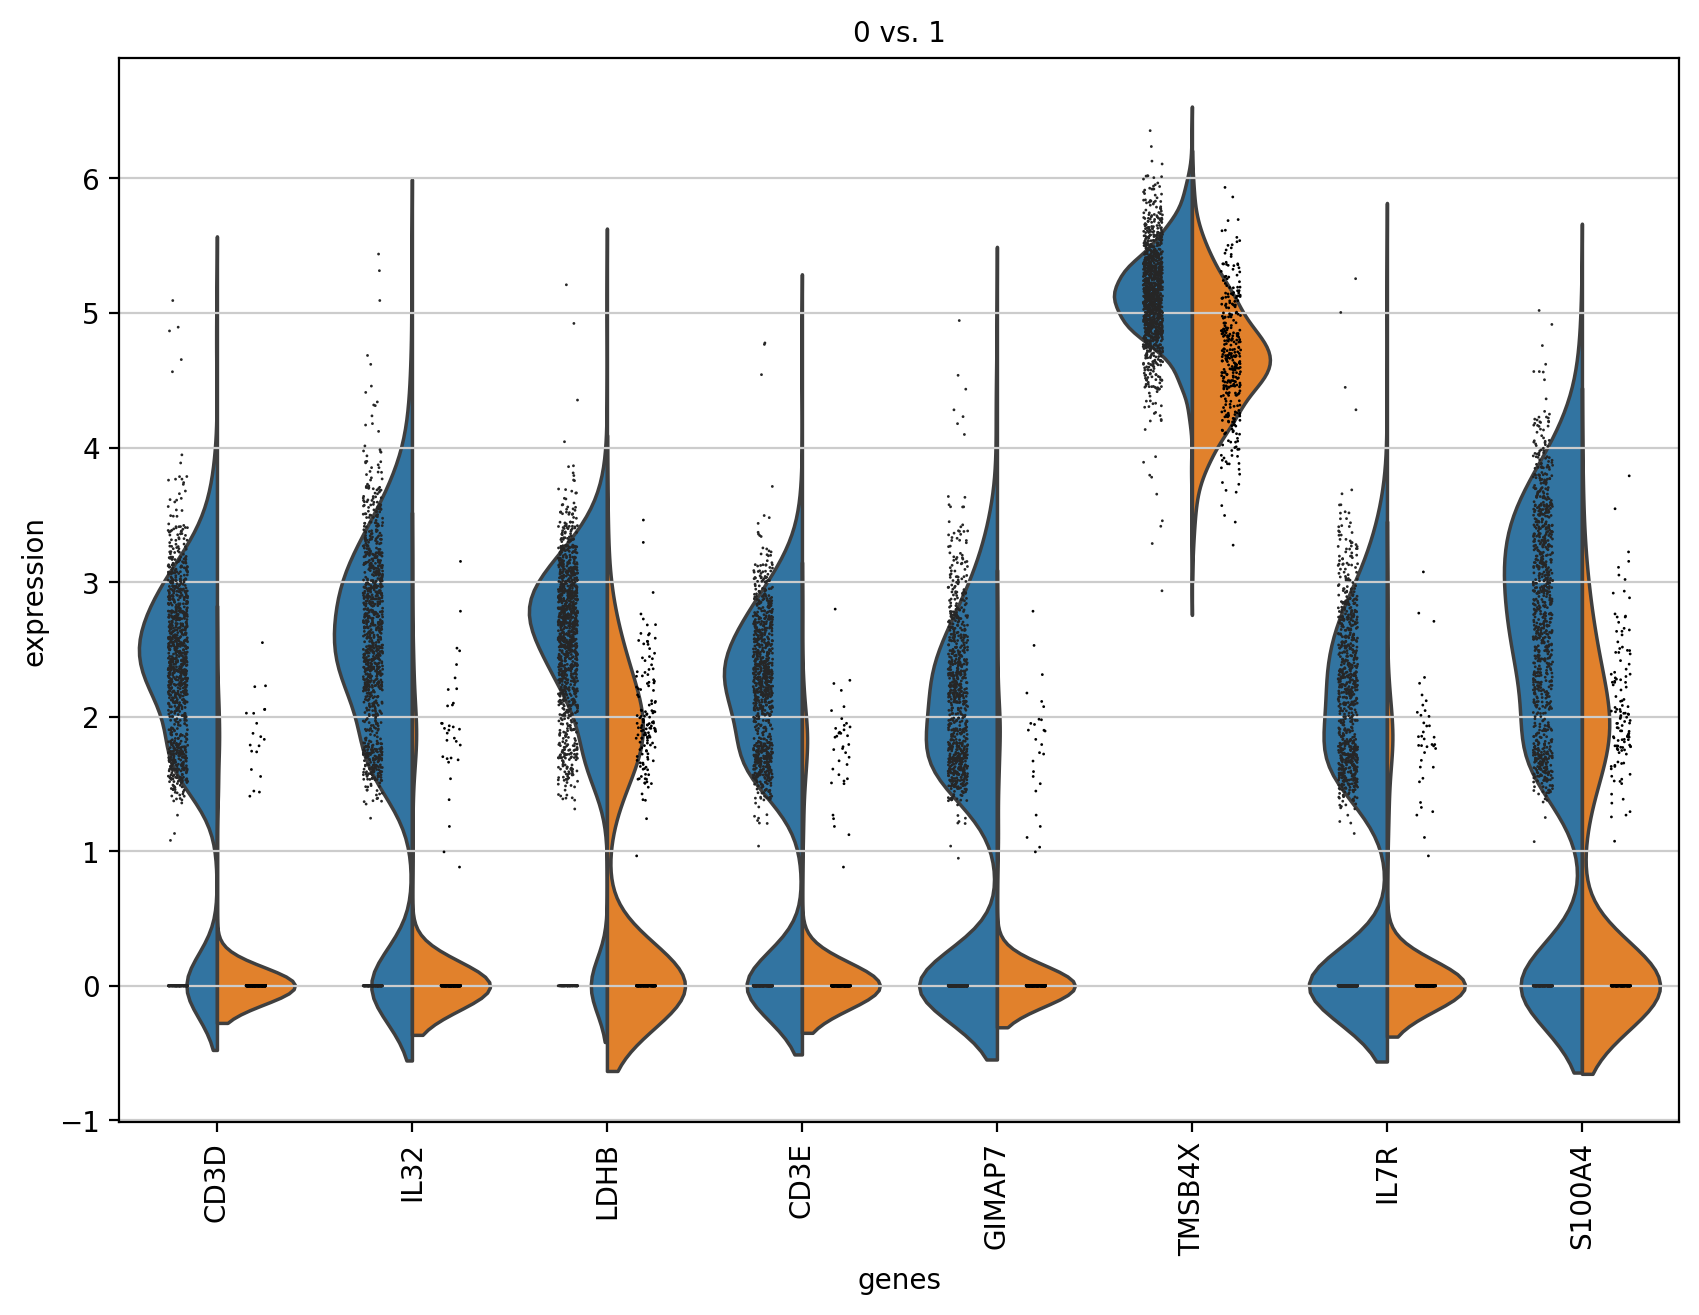

In [87]:
# 单独的两个cluster之间也可以进行marker计算：
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')

sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

# 计算出的基因可以直接用于小提琴图可视化
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

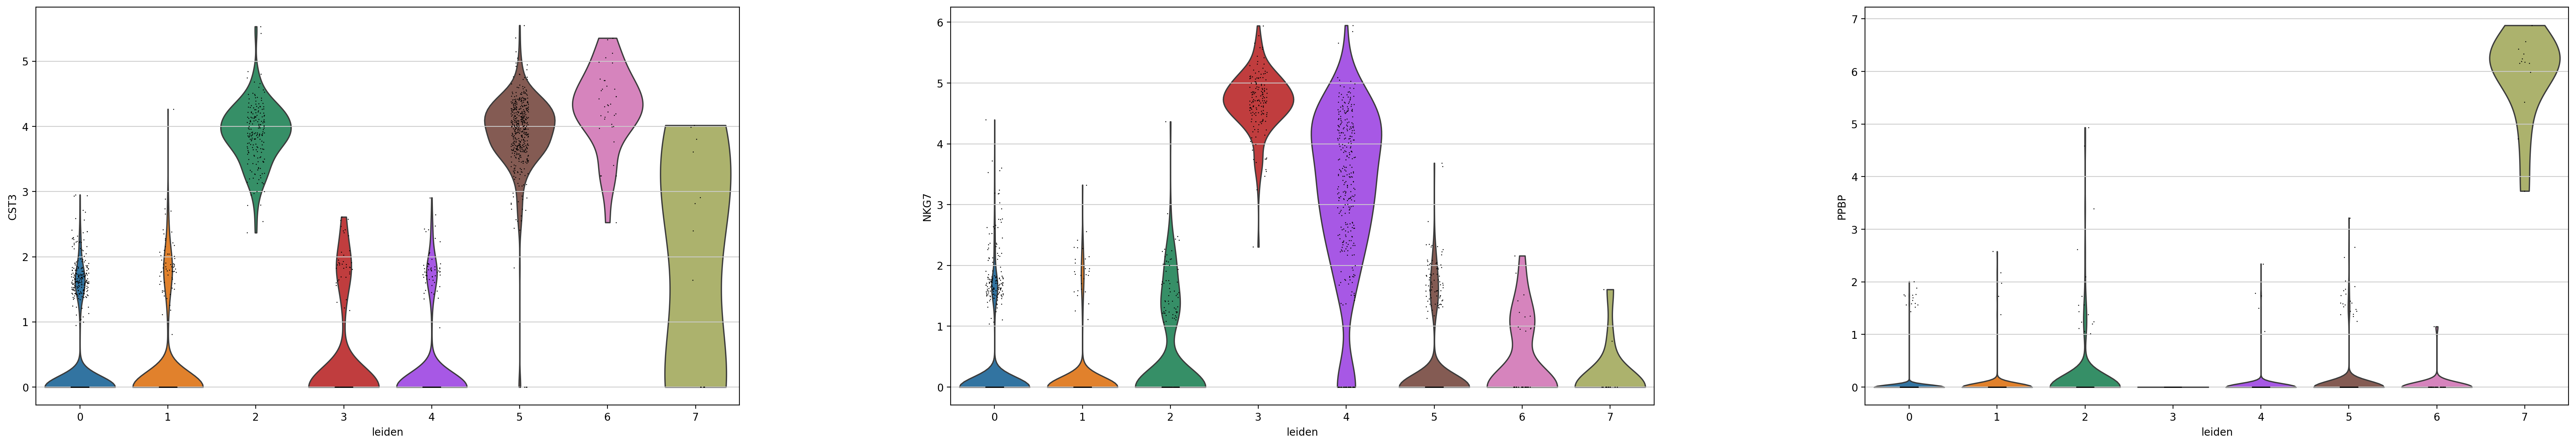

In [ ]:
# 跨类群比较基因
# 画出指定基因在所有cluster中的表达情况：
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [93]:
# 根据已知的细胞标记，注释细胞类型(先验，人工注释)
# 重命名各个cluster：
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


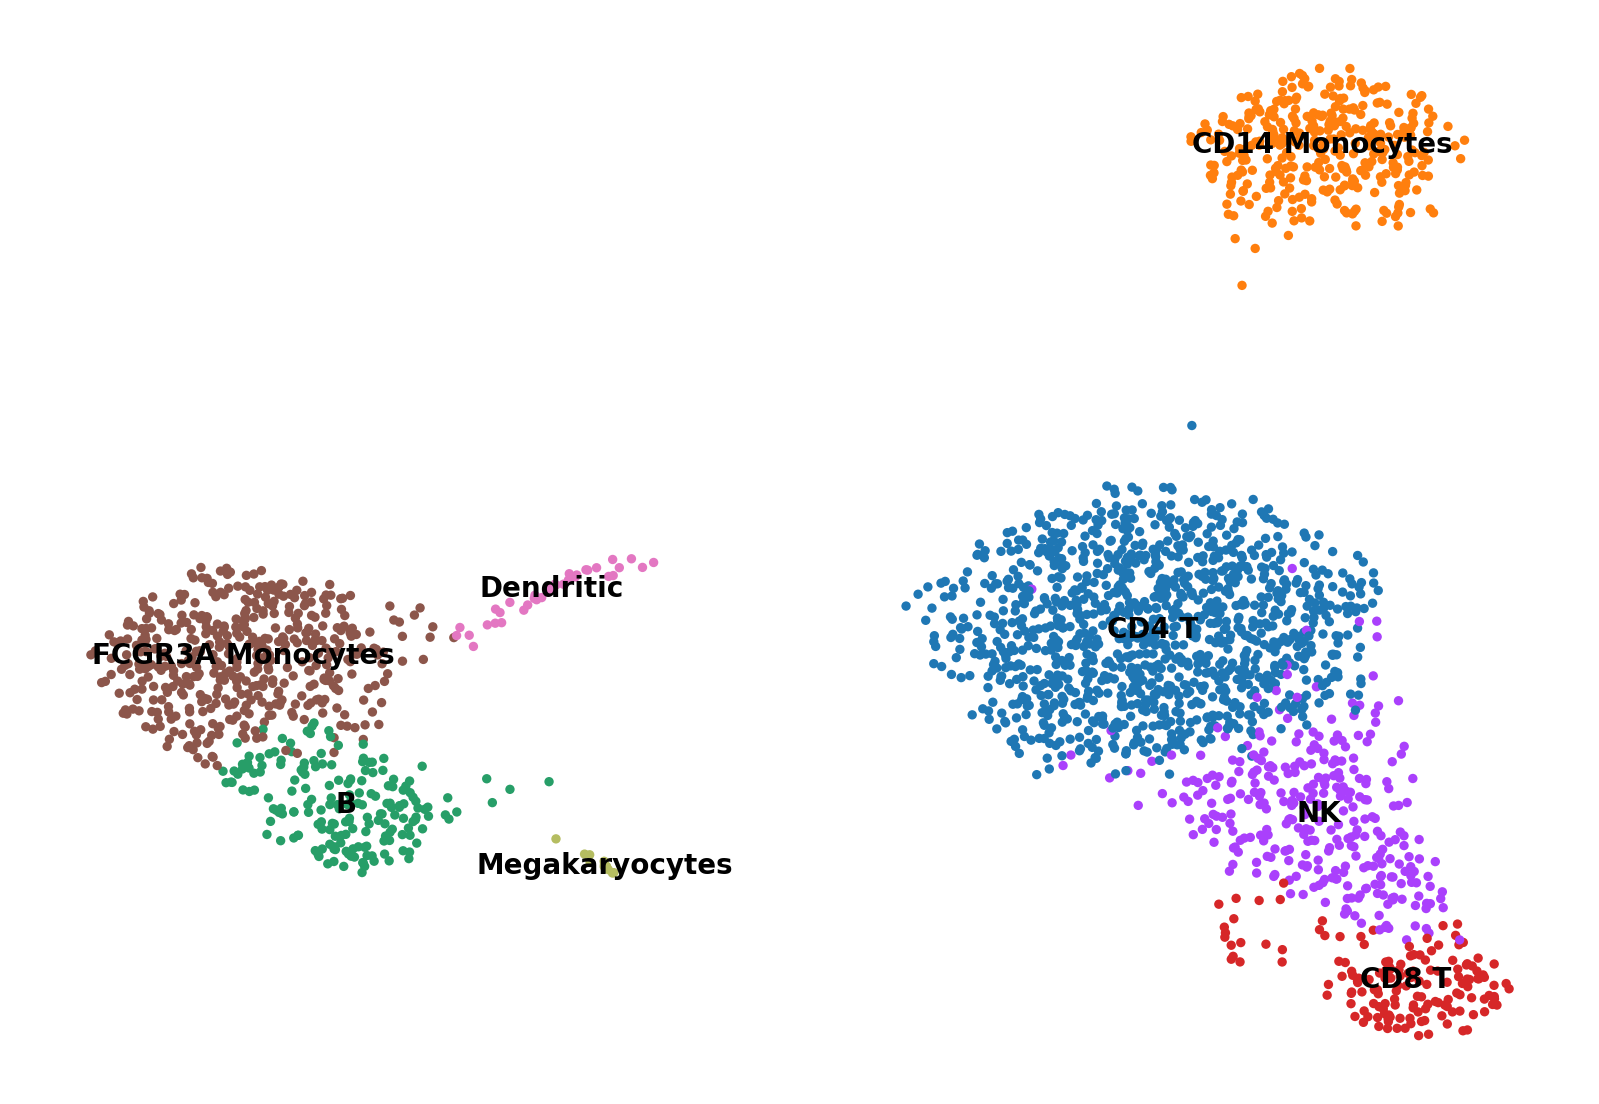

In [ ]:
# 以UMAP的形式进行可视化：
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

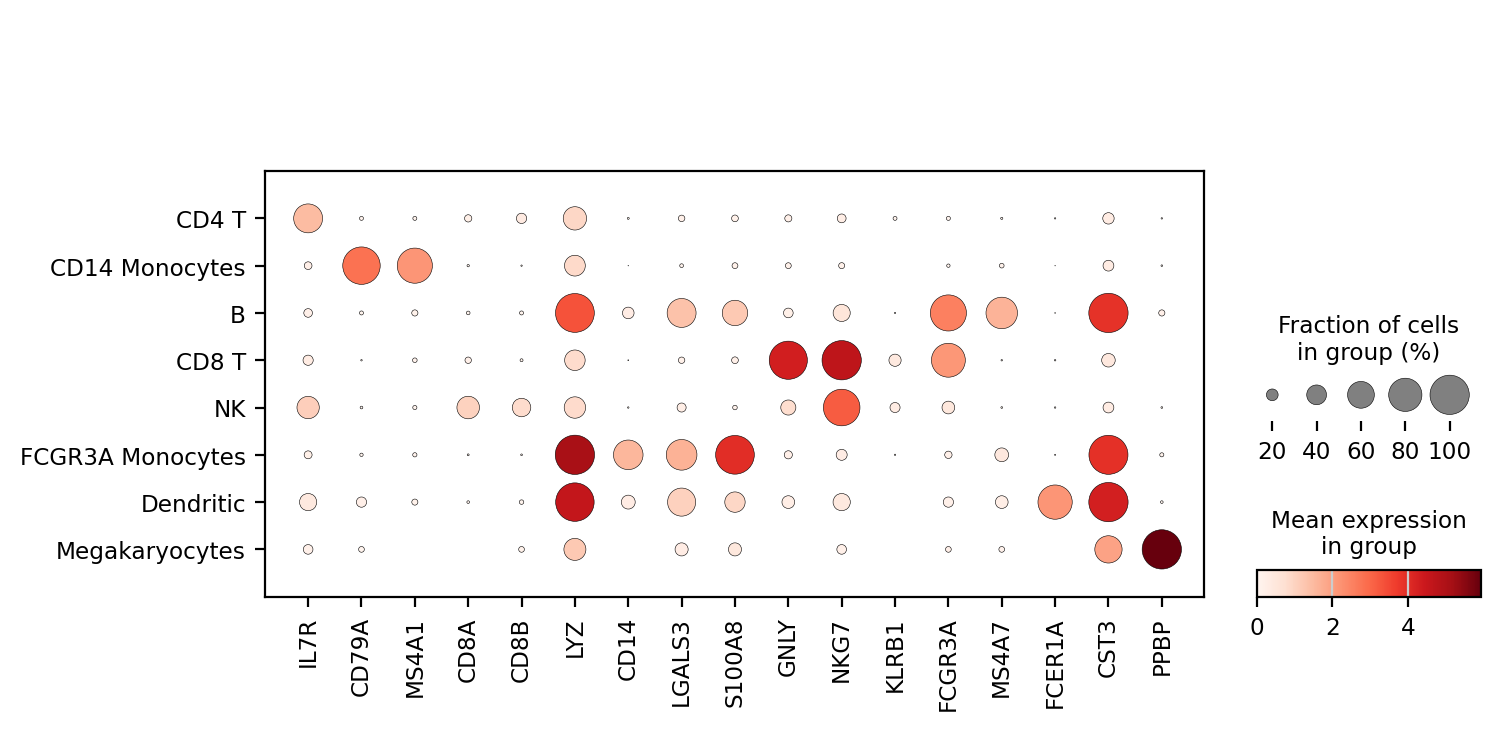

In [99]:
# 作者使用了一些先验的marker，
# 它们是一些常用的细胞标志物：
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

# 以气泡图的形式展示marker基因：
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

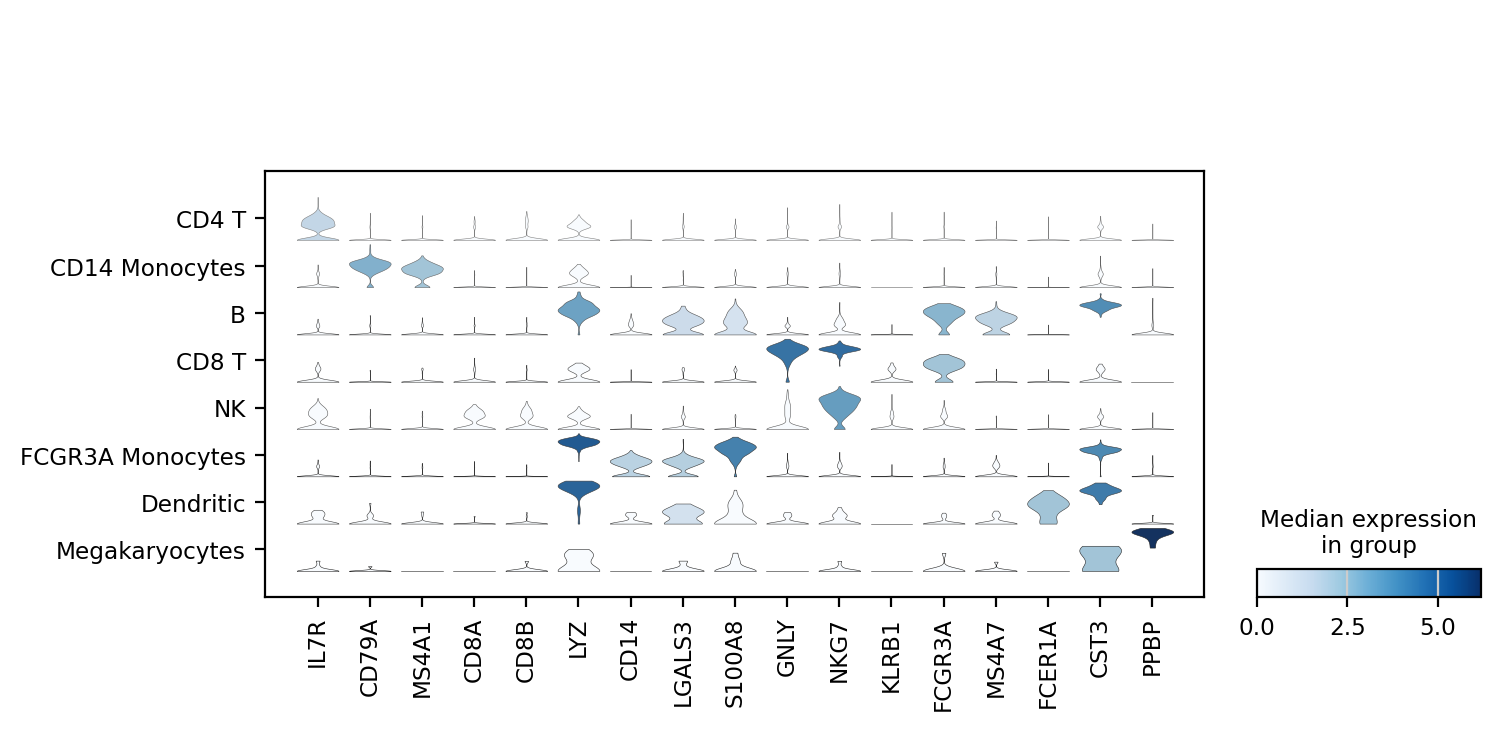

In [103]:
# 以紧凑小提琴的形式展示marker基因：
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden');

In [104]:
# 经过一番计算，adata已经多出了许多的数据内容：
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [109]:
# 保存数据
# 保存压缩文件如果只想将其用于可视化的人共享此文件，减少文件大小的一种简单方法是删除缩放和校正的数据矩阵。
results_file = '/zht/write/pbmc3k.h5ad'
adata.write(results_file, compression='gzip') # 注意，压缩虽然会节省硬盘空间，但是会降低读写速度


# 保存为 h5ad 数据
# 保存原先备份的数据：
adata.raw.to_adata().write('/zht/write/pbmc3k_withoutX.h5ad')
# 读取使用 adata = sc.read_h5ad('./write/pbmc3k_withoutX.h5ad')

# 导出数据子集
# 导出聚类数据
adata.obs[['n_counts', 'louvain_groups']].to_csv('/zht/write/pbmc3k_corrected_louvain_groups.csv')
# 导出PCA数据
adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv('/zht/write/pbmc3k_corrected_X_pca.csv')

KeyError: "None of [Index(['n_counts', 'louvain_groups'], dtype='object')] are in the [columns]"